# Electron Neutrino Interaction Truth Analyzer

This notebook shows an analysis of the number of expected charged-current electron neutrino interactions we expect in MicroBooNE, in both intrinsic nu_e and an LEE-like signal.

There is some breakdown into final-state topologies as well, but of course those can be particularly threshold and interaction model dependent.

The generator used for this study (31 Oct 2018) was GENIE, MicroBooNE "Tune 1". A "Tune 3" study should be done as well. The LEE signal model is from Mark R.-L., and is the combined old and new MiniBooNE-data-derived signal nu_e model.

You are more than welcome to run this notebook. Talk to Wes (wketchum@fnal.gov) for details.

In [1]:
#do some common imports
import os, sys
sys.path.append("../../common/")
from python_tools import *

python tools loaded.


In [2]:
#setup the notebook to make some plots
%matplotlib notebook

In [3]:
# some useful functions
# 
# you may need to comment out the 'numba' bits if your system can't install numba (like the gpvms...)
#

@numba.jit
def costheta_numba(p1x,p1y,p1z,p1mag,
                   p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
                            (p1x*p2x+p1y*p2y+p1z*p2z)/p1mag/p2mag,
                            np.nan),
                   -1.0,1.0)

def eval_costheta(df,suffix1="",suffix2=""):
    return costheta_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,df.loc[:,"p"+suffix1].values,
                          df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values,df.loc[:,"p"+suffix2].values)

    
@numba.jit(nopython=True)
def q3_numba(p1x,p1y,p1z,p2x,p2y,p2z):
    return np.sqrt((p1x-p2x)**2+(p1y-p2y)**2+(p1z-p2z)**2)

def eval_q3(df,suffix1="",suffix2="_mu"):
    return q3_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,
                    df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values)

In [4]:
#setup for reading the files.

# If the hdf5 file exists, we won't need ROOT.
# If not, give a list of root filenames to process, and write the hdf5 file when we're done.

hdf5_filename = "/Users/wketchum/MicroBooNE_Data/genie_studies/nue_cc_studies_tune1.hdf5"
root_filenames = glob.glob("/Users/wketchum/MicroBooNE_Data/genie_studies/nue_opreco_tfs_split*.root")
read_from_ROOT = False
write_to_hdf5 = False

if not os.path.isfile(hdf5_filename):
    read_from_ROOT = True
    write_to_hdf5 = True

In [5]:
#Read from files (ROOT or HDF5)

t_df = []
p_df = []
pot_df = []

if read_from_ROOT:

    file_count = 0
    event_count = 0
    print "Processing %d files" % len(root_filenames)
    for root_filename in root_filenames:
    
        p_df.append(uproot.open(root_filename)['nuana/particle_tree'].pandas.df())
        t_df.append(uproot.open(root_filename)['nuana/mctruth_tree'].pandas.df())
        pot_df.append(uproot.open(root_filename)['potana/pot_tree'].pandas.df())
    
        event_count += len(t_df[-1])
        file_count += 1
        if file_count%1==0:
            print "\tProcessed %d files. %d events processed." % (file_count,event_count)

    p_df = pd.concat(p_df)
    t_df = pd.concat(t_df)
    pot_df = pd.concat(pot_df)

    p_df.set_index(["run","subrun","event","truth_index","p_index"],inplace=True)
    t_df.set_index(["run","subrun","event","truth_index"],inplace=True)
    pot_df.set_index(["run","subrun"],inplace=True)
    
    if write_to_hdf5:
        t_df.to_hdf(hdf5_filename,"t_df")
        p_df.to_hdf(hdf5_filename,"p_df")
        pot_df.to_hdf(hdf5_filename,"pot_df")
else:
    t_df = pd.read_hdf(hdf5_filename,"t_df")
    p_df = pd.read_hdf(hdf5_filename,"p_df")
    pot_df = pd.read_hdf(hdf5_filename,"pot_df")
    
print "Have dataframe objects. Total events is %d." % len(t_df)

Have dataframe objects. Total events is 998000.


In [6]:
# and need to read in the LEE weights file and form a function to apply the weights
lee_weights_root_filename = "/Users/wketchum/MicroBooNE_Data/genie_studies/LEE_combined_weights.root"
w_hist = uproot.open(lee_weights_root_filename)['LEE_combined_nue_CC_weights']

w_bin_edges = np.array(w_hist._fXaxis._fXbins)/1000.
weights = np.array(w_hist.values)
weights = np.append(weights,0.0)

@numba.jit
def get_weight(nu_energy,weight=weights,bin_edges=w_bin_edges):
    return weights[ np.array(np.searchsorted(bin_edges,nu_energy)-1) ]

<IPython.core.display.Javascript object>


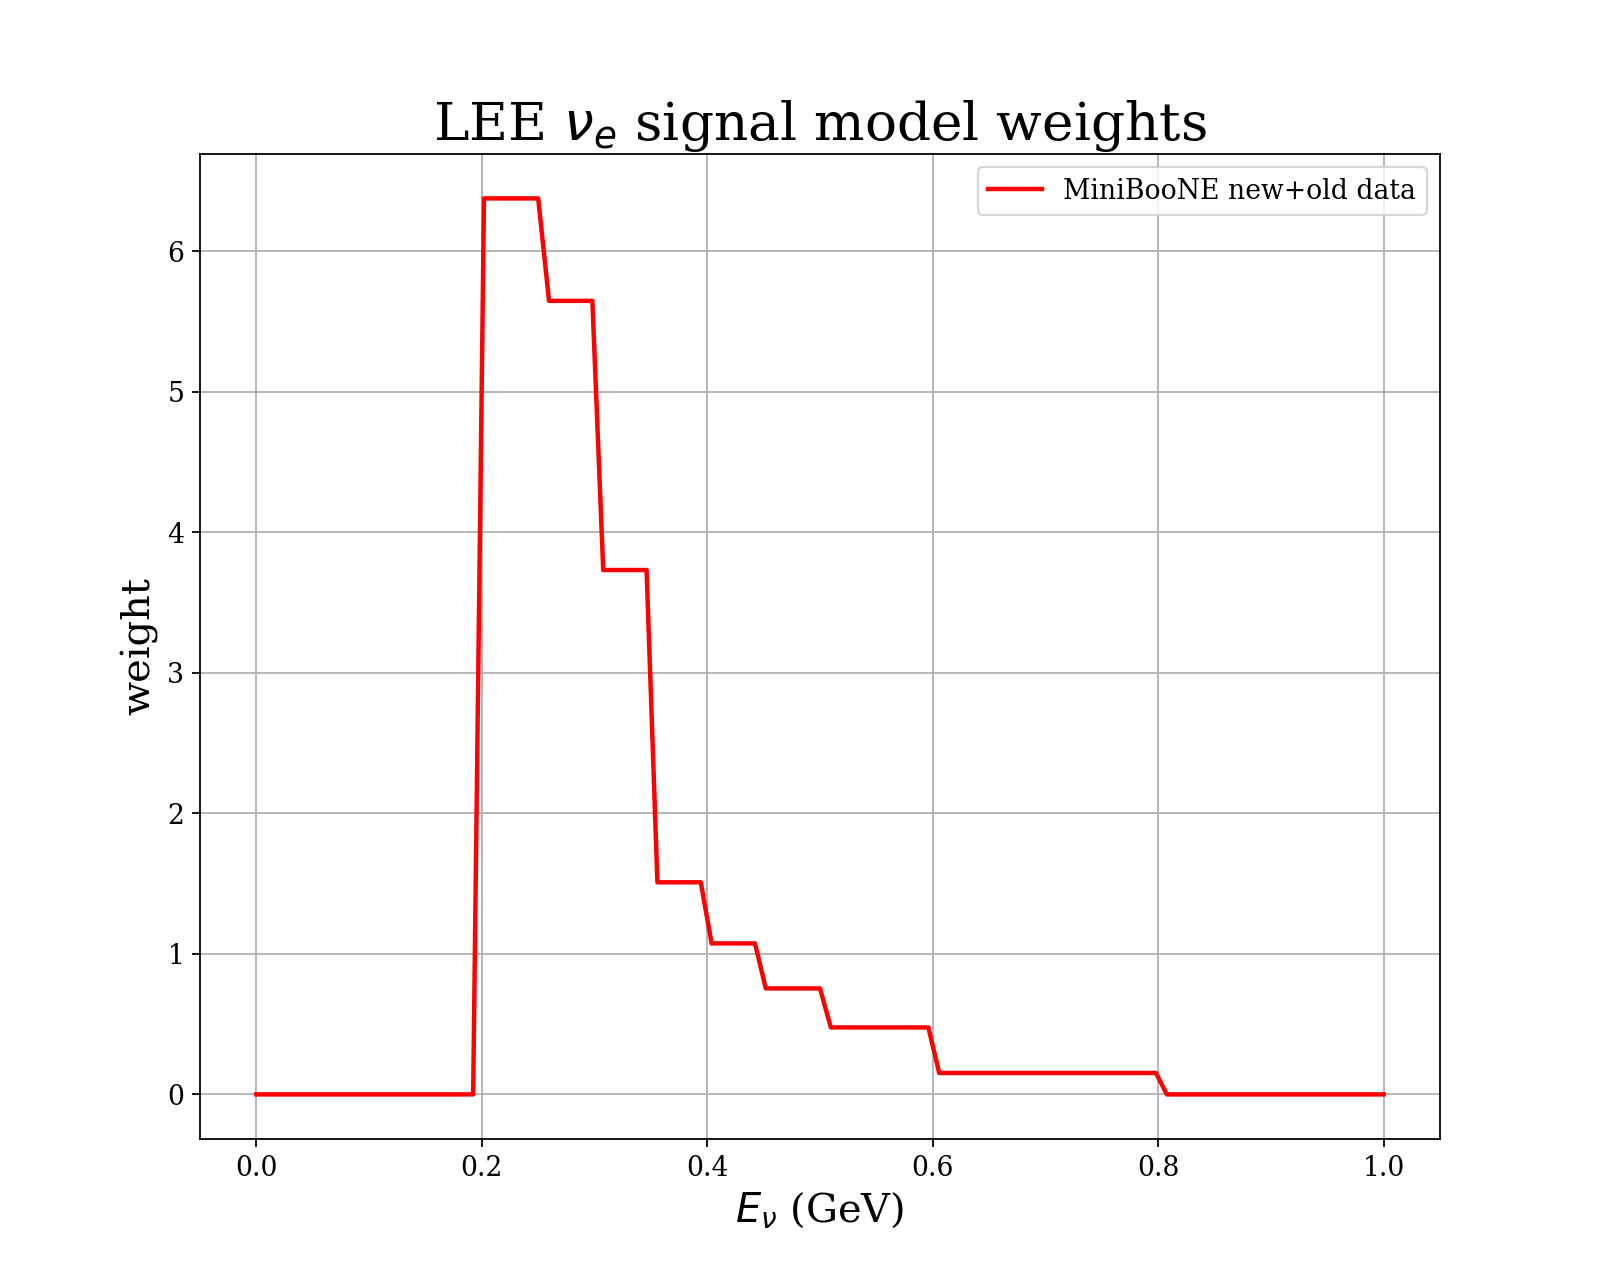

In [7]:
fig,ax = plt.subplots()
nu_energy = np.linspace(0.0,1.0,105)
plt.plot(nu_energy,get_weight(nu_energy),color='red',linewidth=2.0,label="MiniBooNE new+old data")
plt.grid()
plt.legend()
plt.title("LEE $\\nu_e$ signal model weights",fontsize=24)
plt.xlabel("$E_\\nu$ (GeV)",fontsize=18)
plt.ylabel("weight",fontsize=18)
plt.show()
plt.savefig("plots/lee_weights.pdf")

In [8]:
# calculate integrated POT for all the events we have

TOTAL_POT = pot_df["totpot"].sum()
TOTAL_EVENTS = len(t_df)
print"\n\n"
print "Total CC nu_e events of %d in POT of %E. Events per 1e20 POT is %f" % (TOTAL_EVENTS,
                                                                              TOTAL_POT,
                                                                              TOTAL_EVENTS/(TOTAL_POT/1e20))
print"\n\n"




Total CC nu_e events of 998000 in POT of 4.836918E+23. Events per 1e20 POT is 206.329715





In [9]:
# setup some particle accounting
# 
# Here, we consider 0 KE thresholds, and a 20 MeV threshold for electrons, and 40 MeV threshold for protons
# No thresholds on either charged or neutral pions

df_n = pd.DataFrame()
df_n["is_e"] = ((p_df["status"]==1)&(p_df["pdgcode"]==11)).replace(False,np.nan)
df_n["is_e_20MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==11)&((p_df["e"]-p_df["mass"])>0.02)).replace(False,np.nan)
df_n["is_e_35MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==11)&((p_df["e"]-p_df["mass"])>0.035)).replace(False,np.nan)
df_n["is_p"] = ((p_df["status"]==1)&(p_df["pdgcode"]==2212)).replace(False,np.nan)
df_n["is_p_40MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==2212)&((p_df["e"]-p_df["mass"])>0.04)).replace(False,np.nan)
df_n["is_p_60MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==2212)&((p_df["e"]-p_df["mass"])>0.06)).replace(False,np.nan)
df_n["is_pi"] = ((p_df["status"]==1)&((p_df["pdgcode"]==211)^(p_df["pdgcode"]==-211)^(p_df["pdgcode"]==111))).replace(False,np.nan)
df_n = df_n.groupby(["run","event","truth_index"]).agg("sum").rename(columns={"is_e":"n_e",
                                                                              "is_e_20MeV":"n_e_20MeV",
                                                                              "is_e_35MeV":"n_e_35MeV",
                                                                              "is_p":"n_p",
                                                                              "is_p_40MeV":"n_p_40MeV",
                                                                              "is_p_60MeV":"n_p_60MeV",
                                                                              "is_pi":"n_pi"})

In [10]:
# and, let's pull out for particle by particle comparisons the leading 4 protons, electron, and neutrino

p_df["ke"] = p_df["e"]-p_df["mass"]
p_df_p_grouped = p_df.query("status==1 and pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"])
p_df_p1 = p_df_p_grouped.nth(0)
p_df_p2 = p_df_p_grouped.nth(1)
p_df_p3 = p_df_p_grouped.nth(2)
p_df_p4 = p_df_p_grouped.nth(3)

p_df_e = p_df.query("status==1 and pdgcode==11").groupby(["run","event","truth_index"]).first()

p_df_nu = p_df.query("status==0 and pdgcode==12").groupby(["run","event","truth_index"]).first()

In [11]:
# now, make a final dataframe with the truth info, and merge in the particle and topology counting info

df_ev_t = t_df.copy()
df_ev_t = df_ev_t.merge(p_df_nu,how="left",on=["run","event","truth_index"],suffixes=["","_nu"])
df_ev_t = df_ev_t.merge(p_df_e,how="left",on=["run","event","truth_index"],suffixes=["","_e"])
df_ev_t = df_ev_t.merge(p_df_p1,how="left",on=["run","event","truth_index"],suffixes=["","_p1"])
df_ev_t = df_ev_t.merge(p_df_p2,how="left",on=["run","event","truth_index"],suffixes=["","_p2"])
df_ev_t = df_ev_t.merge(p_df_p3,how="left",on=["run","event","truth_index"],suffixes=["","_p3"])
df_ev_t = df_ev_t.merge(p_df_p3,how="left",on=["run","event","truth_index"],suffixes=["","_p4"])
df_ev_t = df_ev_t.merge(df_n,how="left",on=["run","event","truth_index"])

In [12]:
# use our LEE weighting function and apply a weight
# note that now, the sum of all rows is the total number of intrinsic nue events
# while the sum of all weights is the total number of LEE signal events

df_ev_t["nue_weight"] = 1e20/TOTAL_POT
df_ev_t["lee_weight"] = get_weight(df_ev_t["e"].values)*1e20/TOTAL_POT


print "\n\nTotal intrinsic nu_e events is %f per 1e20 POT" % (df_ev_t["nue_weight"].sum())
print "Total signal LEE events is %f per 1e20 POT\n\n" % (df_ev_t["lee_weight"].sum())



Total intrinsic nu_e events is 206.329715 per 1e20 POT
Total signal LEE events is 48.596635 per 1e20 POT




In [13]:
#calculations for fiducial volumes...

av_min_x = np.min(df_ev_t["start_x"])/100.
av_max_x = np.max(df_ev_t["start_x"])/100.
av_min_y = np.min(df_ev_t["start_y"])/100.
av_max_y = np.max(df_ev_t["start_y"])/100.
av_min_z = np.min(df_ev_t["start_z"])/100.
av_max_z = np.max(df_ev_t["start_z"])/100.

active_volume = (av_max_x-av_min_x)*(av_max_y-av_min_y)*(av_max_z-av_min_z)

print "\n\n"
print "GENIE generated active volume: %.1f m^3" % active_volume

volume_10_10_10 = (av_max_x-av_min_x-0.20)*(av_max_y-av_min_y-0.20)*(av_max_z-av_min_z-0.20)
volume_10_20_10 = (av_max_x-av_min_x-0.20)*(av_max_y-av_min_y-0.40)*(av_max_z-av_min_z-0.20)
volume_pandora = (av_max_x-av_min_x-0.20)*(av_max_y-av_min_y-0.40)*(av_max_z-av_min_z-0.60)

print "\tfiducial cut of [10cm,10cm,10cm], volume = %.1f m^3, ratio to active = %.3f" % (volume_10_10_10,volume_10_10_10/active_volume)
print "\tfiducial cut of [10cm,20cm,10cm], volume = %.1f m^3, ratio to active = %.3f" % (volume_10_20_10,volume_10_20_10/active_volume)
print "\tfiducial cut of [10cm,20cm,10cm/50cm], volume = %.1f m^3, ratio to active = %.3f" % (volume_pandora,volume_pandora/active_volume)
print "\n\n"




GENIE generated active volume: 61.9 m^3
	fiducial cut of [10cm,10cm,10cm], volume = 51.2 m^3, ratio to active = 0.827
	fiducial cut of [10cm,20cm,10cm], volume = 46.4 m^3, ratio to active = 0.749
	fiducial cut of [10cm,20cm,10cm/50cm], volume = 44.6 m^3, ratio to active = 0.720





In [14]:
#write the datframe to a ROOT tree
root_output_filename="/Users/wketchum/MicroBooNE_Data/genie_studies/nue_cc_studies_tune1.root"

if(len(root_output_filename)>0):
    import root_pandas
    df_ev_t.to_root(root_output_filename, key='nue_cc_tree')

Welcome to JupyROOT 6.14/04


/Library/Python/2.7/site-packages/root_numpy/_tree.py:571: UserWarning: converter for dtype('O') is not implemented (skipping)
  cobj = _librootnumpy.array2tree_toCObj(arr, name=name, tree=incobj)


In [15]:
# establish some queries
# for dumbness, I'm calling 'M'>1, N'>=1, and 'X'>=0

query_1e0p0pi = "n_e_20MeV==1 and n_p_40MeV==0 and n_pi==0"
query_1e1p0pi = "n_e_20MeV==1 and n_p_40MeV==1 and n_pi==0"
query_1eMp0pi = "n_e_20MeV==1 and n_p_40MeV>1 and n_pi==0"
query_1eNp0pi = "n_e_20MeV==1 and n_p_40MeV>=1 and n_pi==0"
query_1eXp0pi = "n_e_20MeV==1 and n_pi==0"
query_1eXpNpi = "n_e_20MeV==1 and n_pi>0"
query_1eXpXpi = "n_e_20MeV==1"
query_0eXpXpi = "n_e_20MeV==0"

query_1e1p0pi_DL = "n_e_35MeV==1 and n_p_60MeV==1 and n_pi==0"

df_1e0p0pi = df_ev_t.query(query_1e0p0pi)
df_1e1p0pi = df_ev_t.query(query_1e1p0pi)
df_1eNp0pi = df_ev_t.query(query_1eNp0pi)
df_1eMp0pi = df_ev_t.query(query_1eMp0pi)
df_1eXp0pi = df_ev_t.query(query_1eXp0pi)
df_1eXpNpi = df_ev_t.query(query_1eXpNpi)
df_1eXpXpi = df_ev_t.query(query_1eXpXpi)
df_0eXpXpi = df_ev_t.query(query_0eXpXpi)

df_1e1p0pi_DL = df_ev_t.query(query_1e1p0pi_DL)


<IPython.core.display.Javascript object>


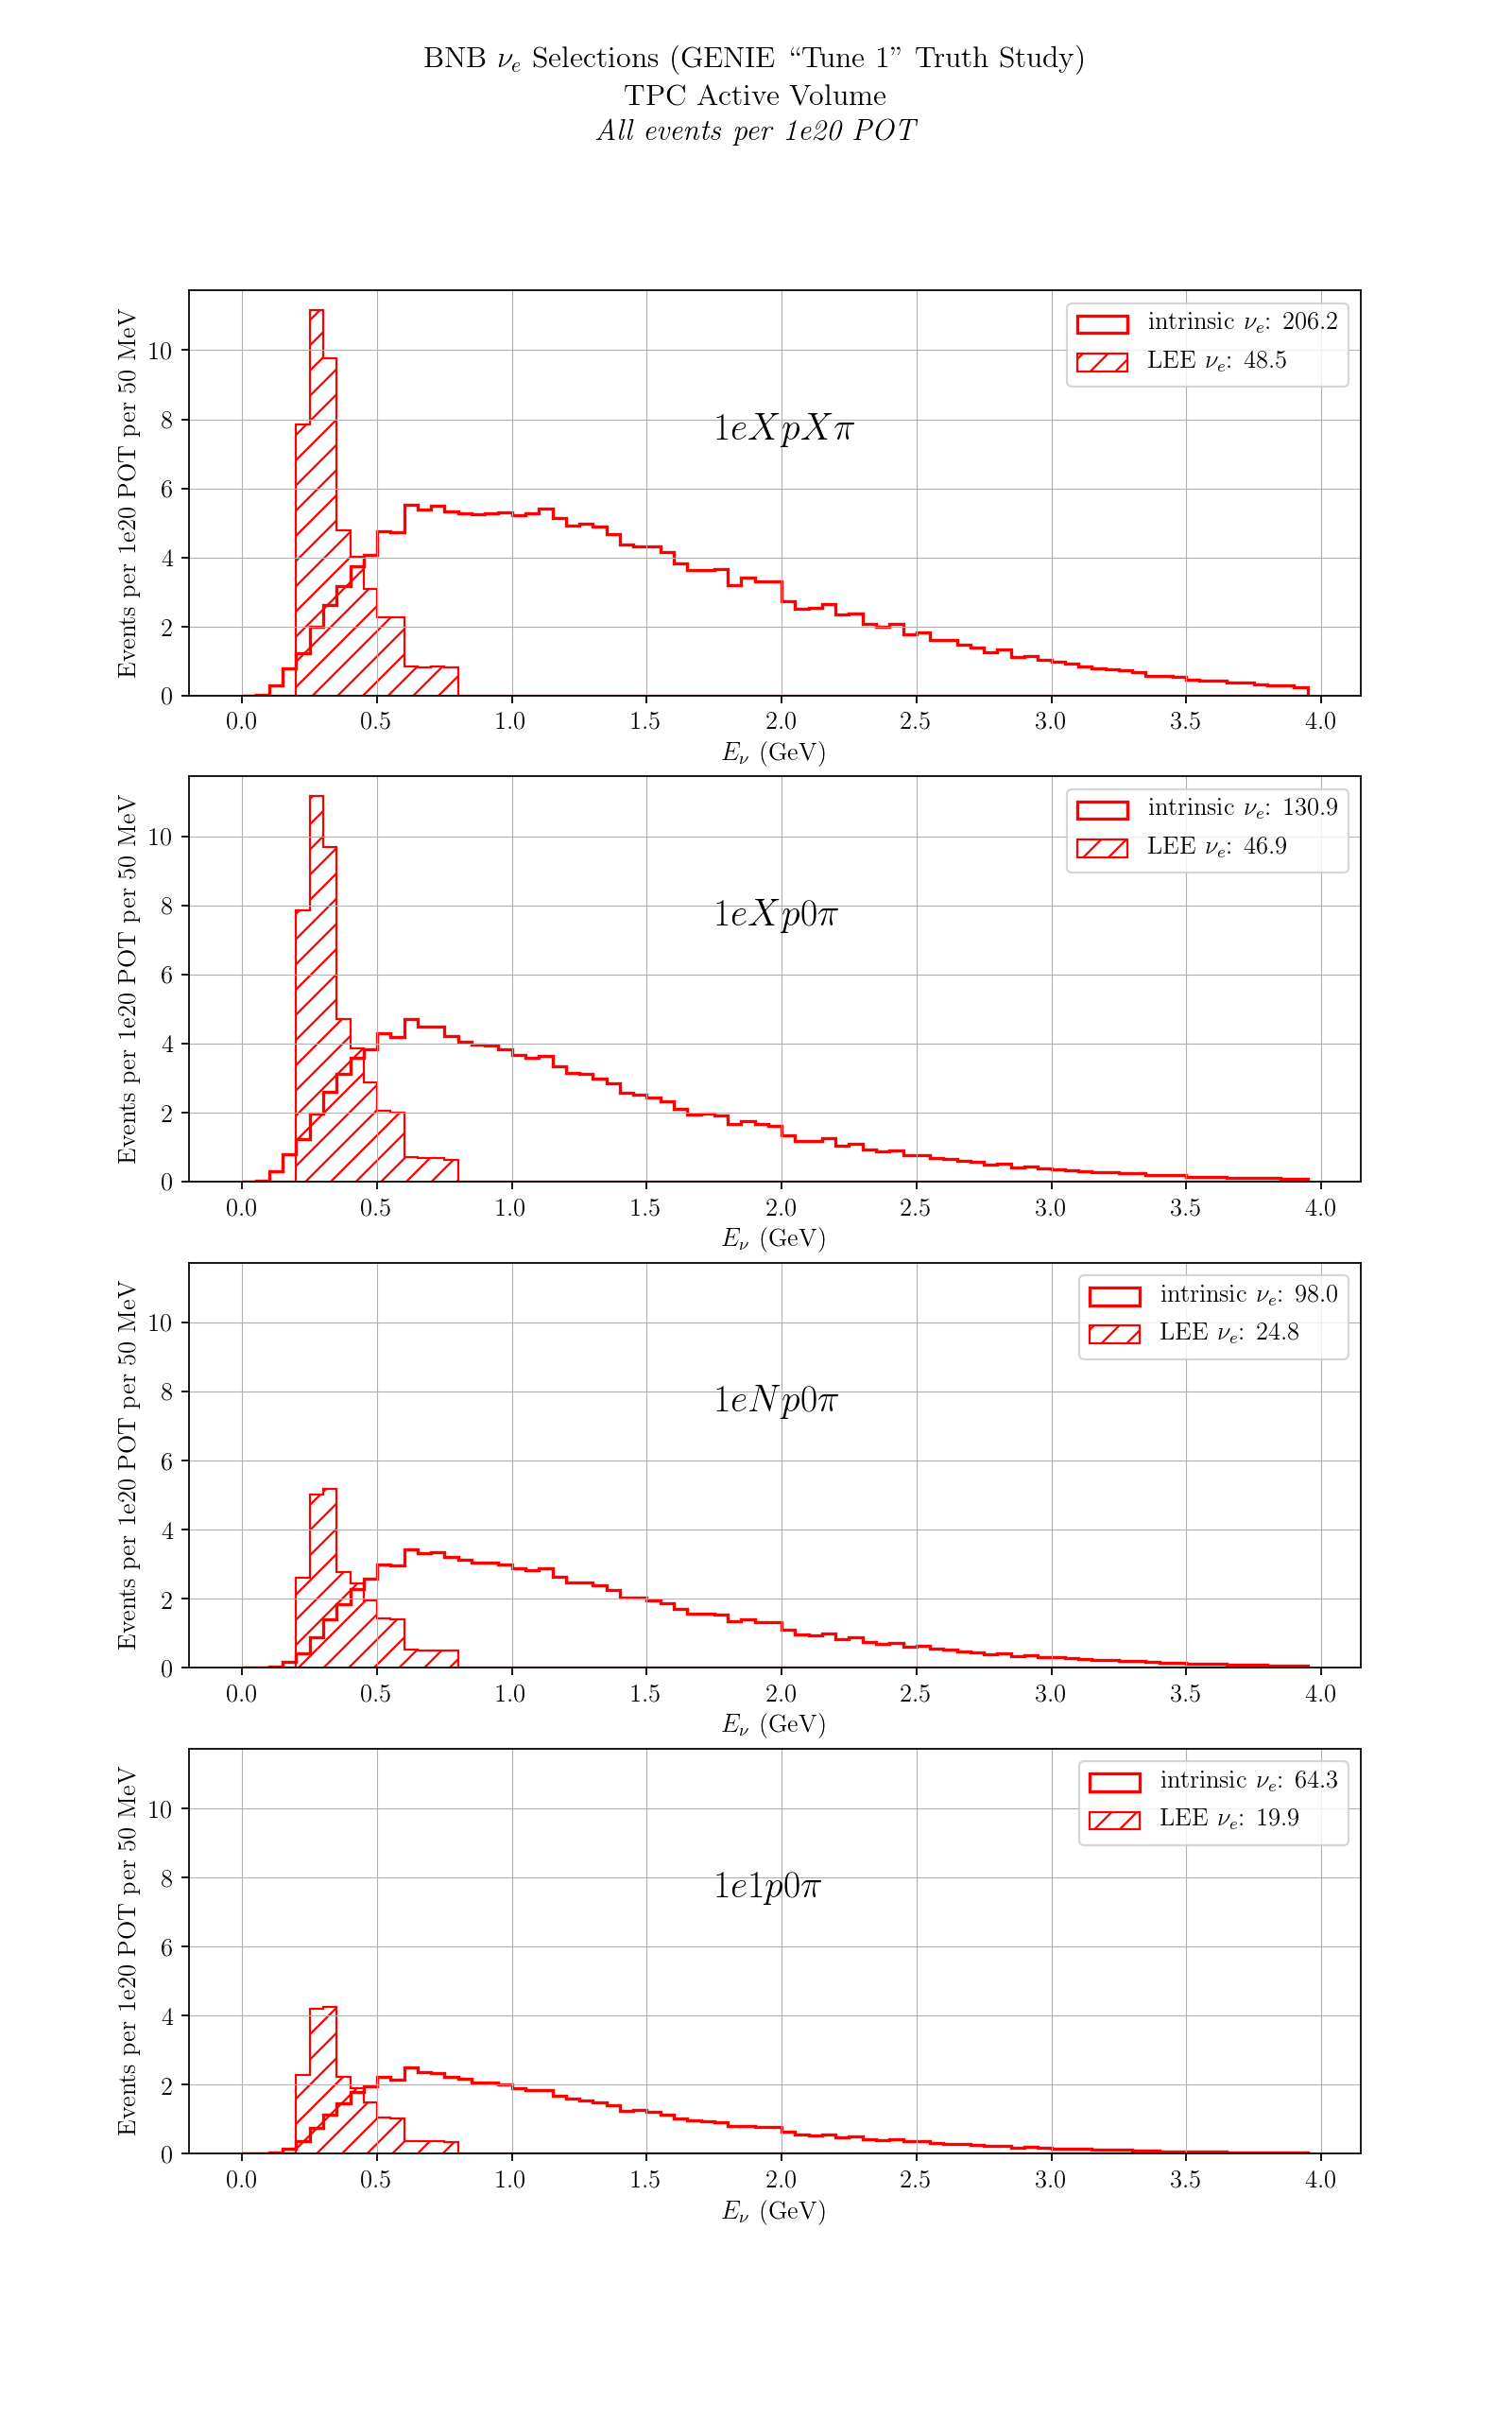

In [16]:
plt.rc('text', usetex=True)

hists_to_plot = [{'var':'e','cut':'1','weight':'lee_weight',
                  'label':'LEE $\\nu_e$','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'1','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$','facecolor':'red','edgecolor':'red','fill':False, 'linewidth':1.5}
                 ]
df_selections = [df_1eXpXpi,
                 df_1eXp0pi,
                 df_1eNp0pi,
                 df_1e1p0pi]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,4.0,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],stacked=False)
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.45, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events.pdf")

<IPython.core.display.Javascript object>


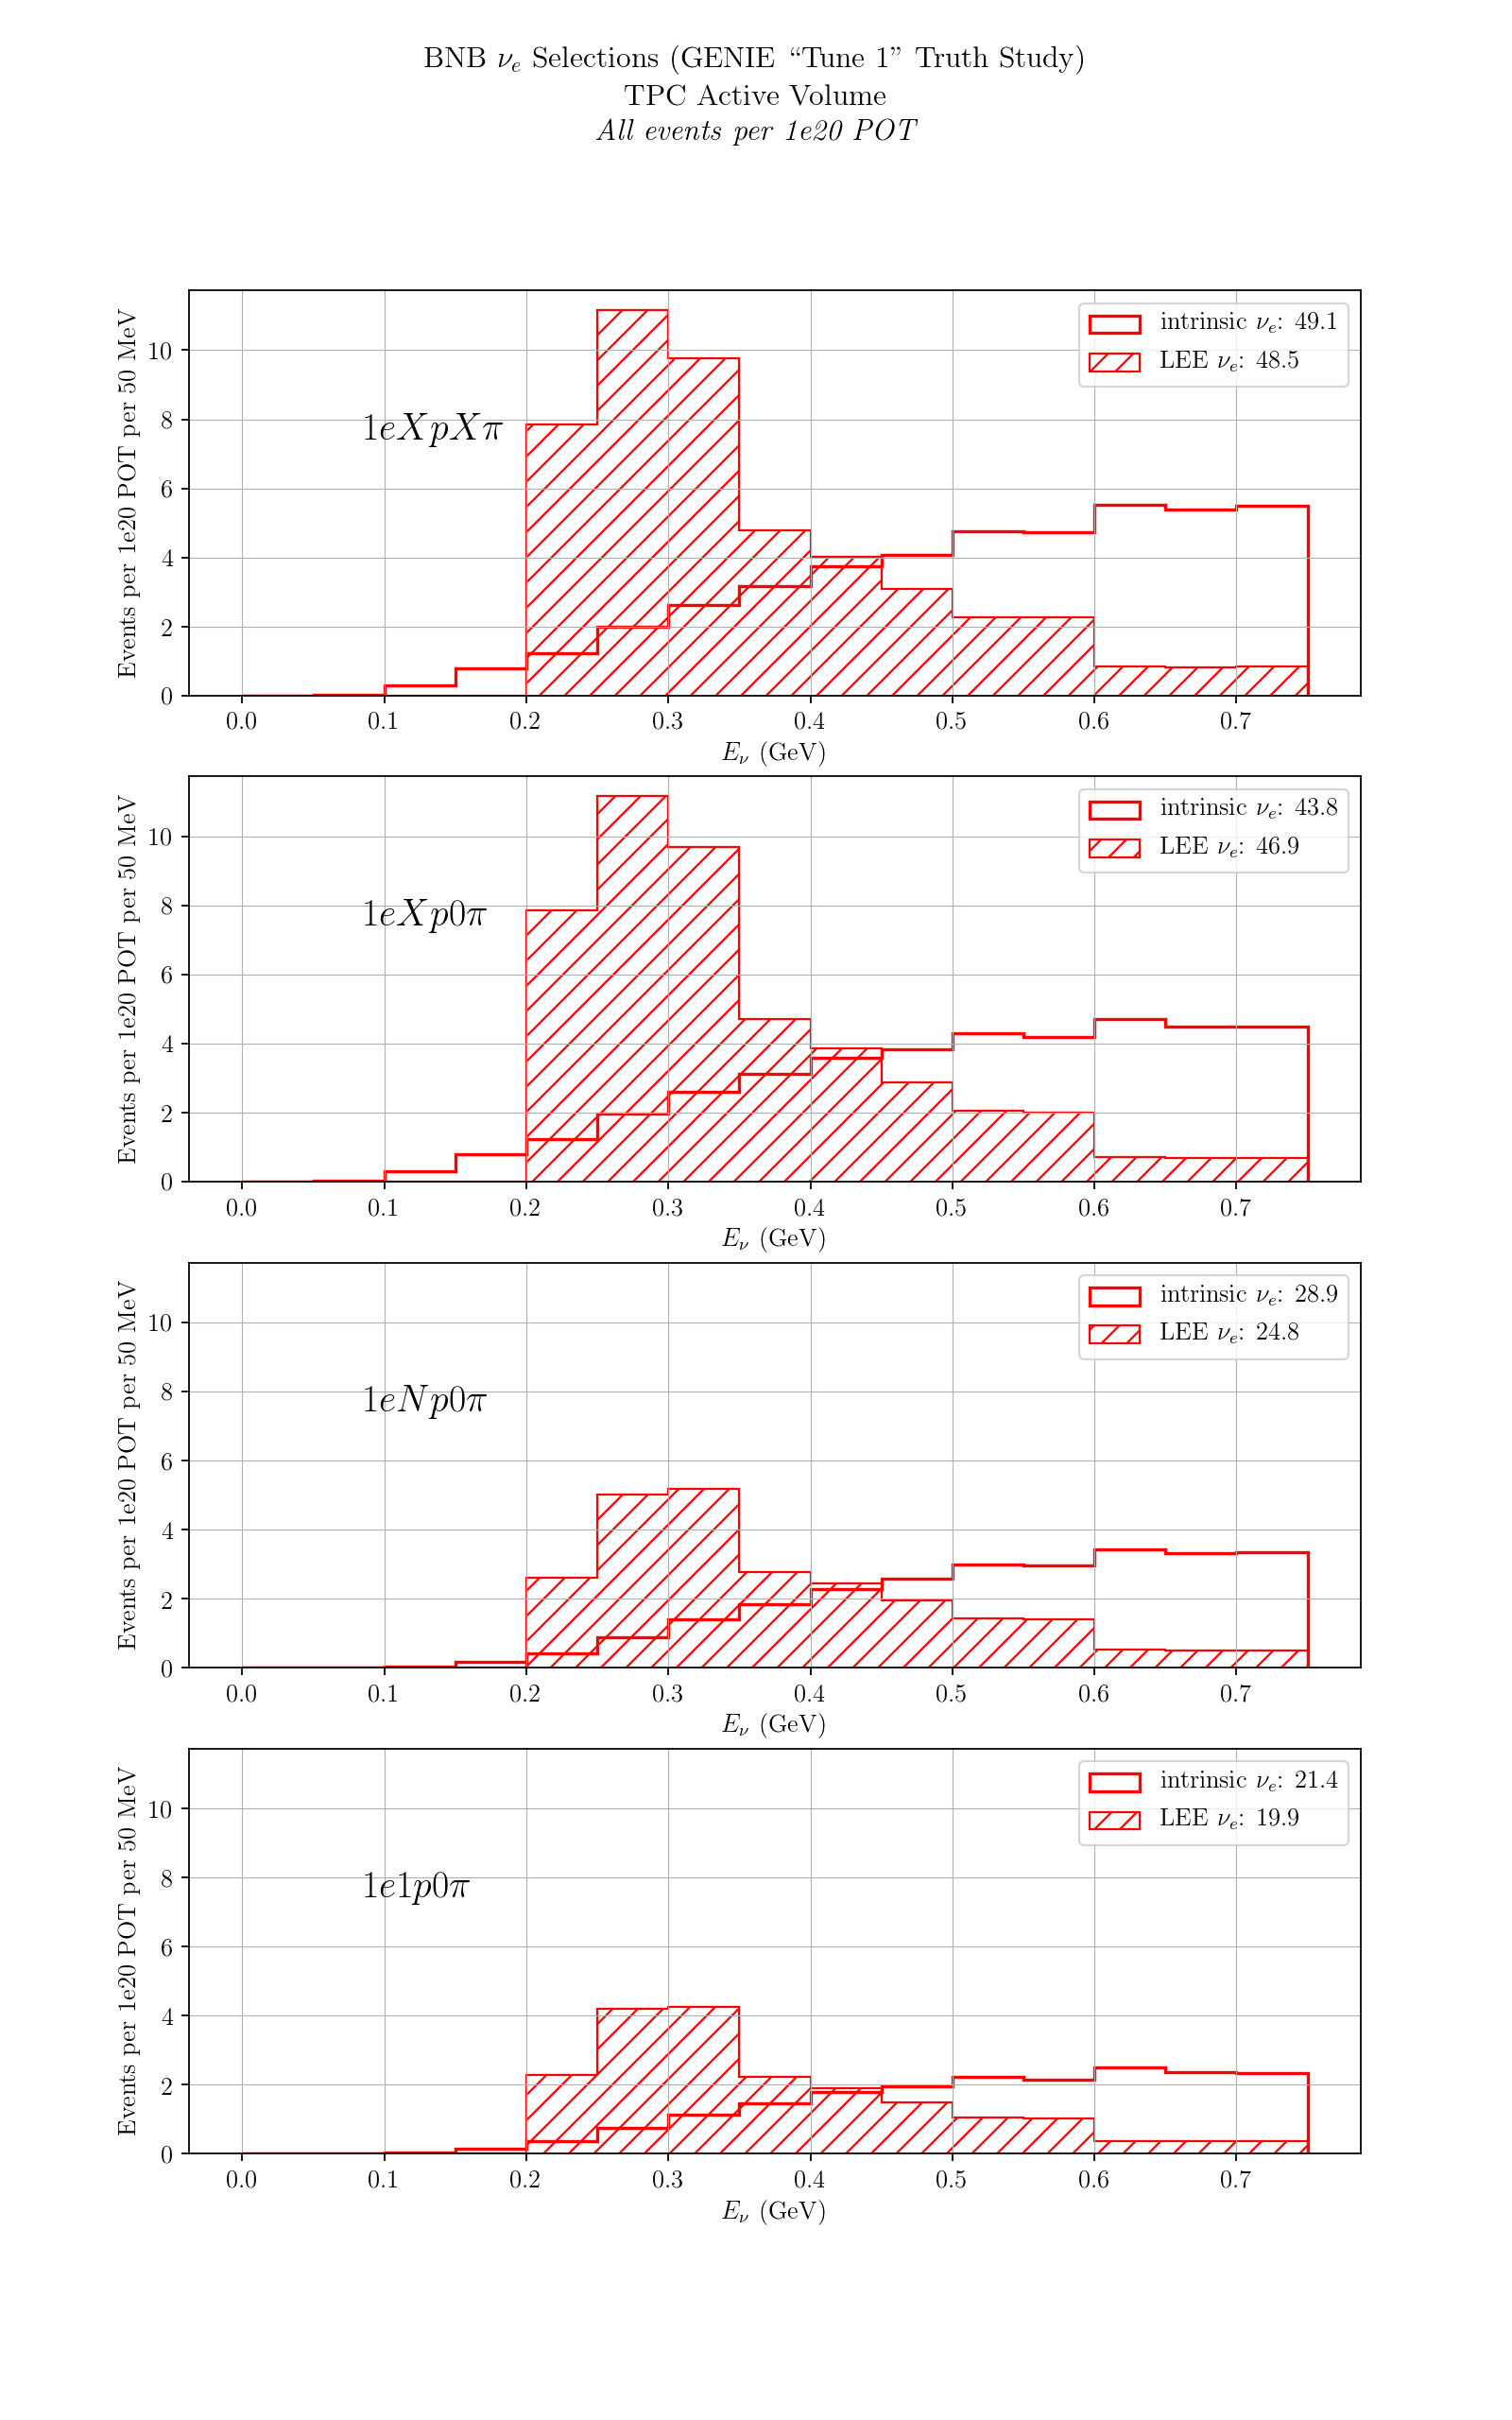

In [17]:
plt.rc('text', usetex=True)

df_selections = [df_1eXpXpi.query("e<0.8"),
                 df_1eXp0pi.query("e<0.8"),
                 df_1eNp0pi.query("e<0.8"),
                 df_1e1p0pi.query("e<0.8")]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

hists_to_plot = [{'var':'e','cut':'1','weight':'lee_weight',
                  'label':'LEE $\\nu_e$','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'1','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$','facecolor':'red','edgecolor':'red','fill':False, 'linewidth':1.5}
                ]

bins_energy = np.arange(0,0.8,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],stacked=False)
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.15, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events_zoom.pdf")

<IPython.core.display.Javascript object>


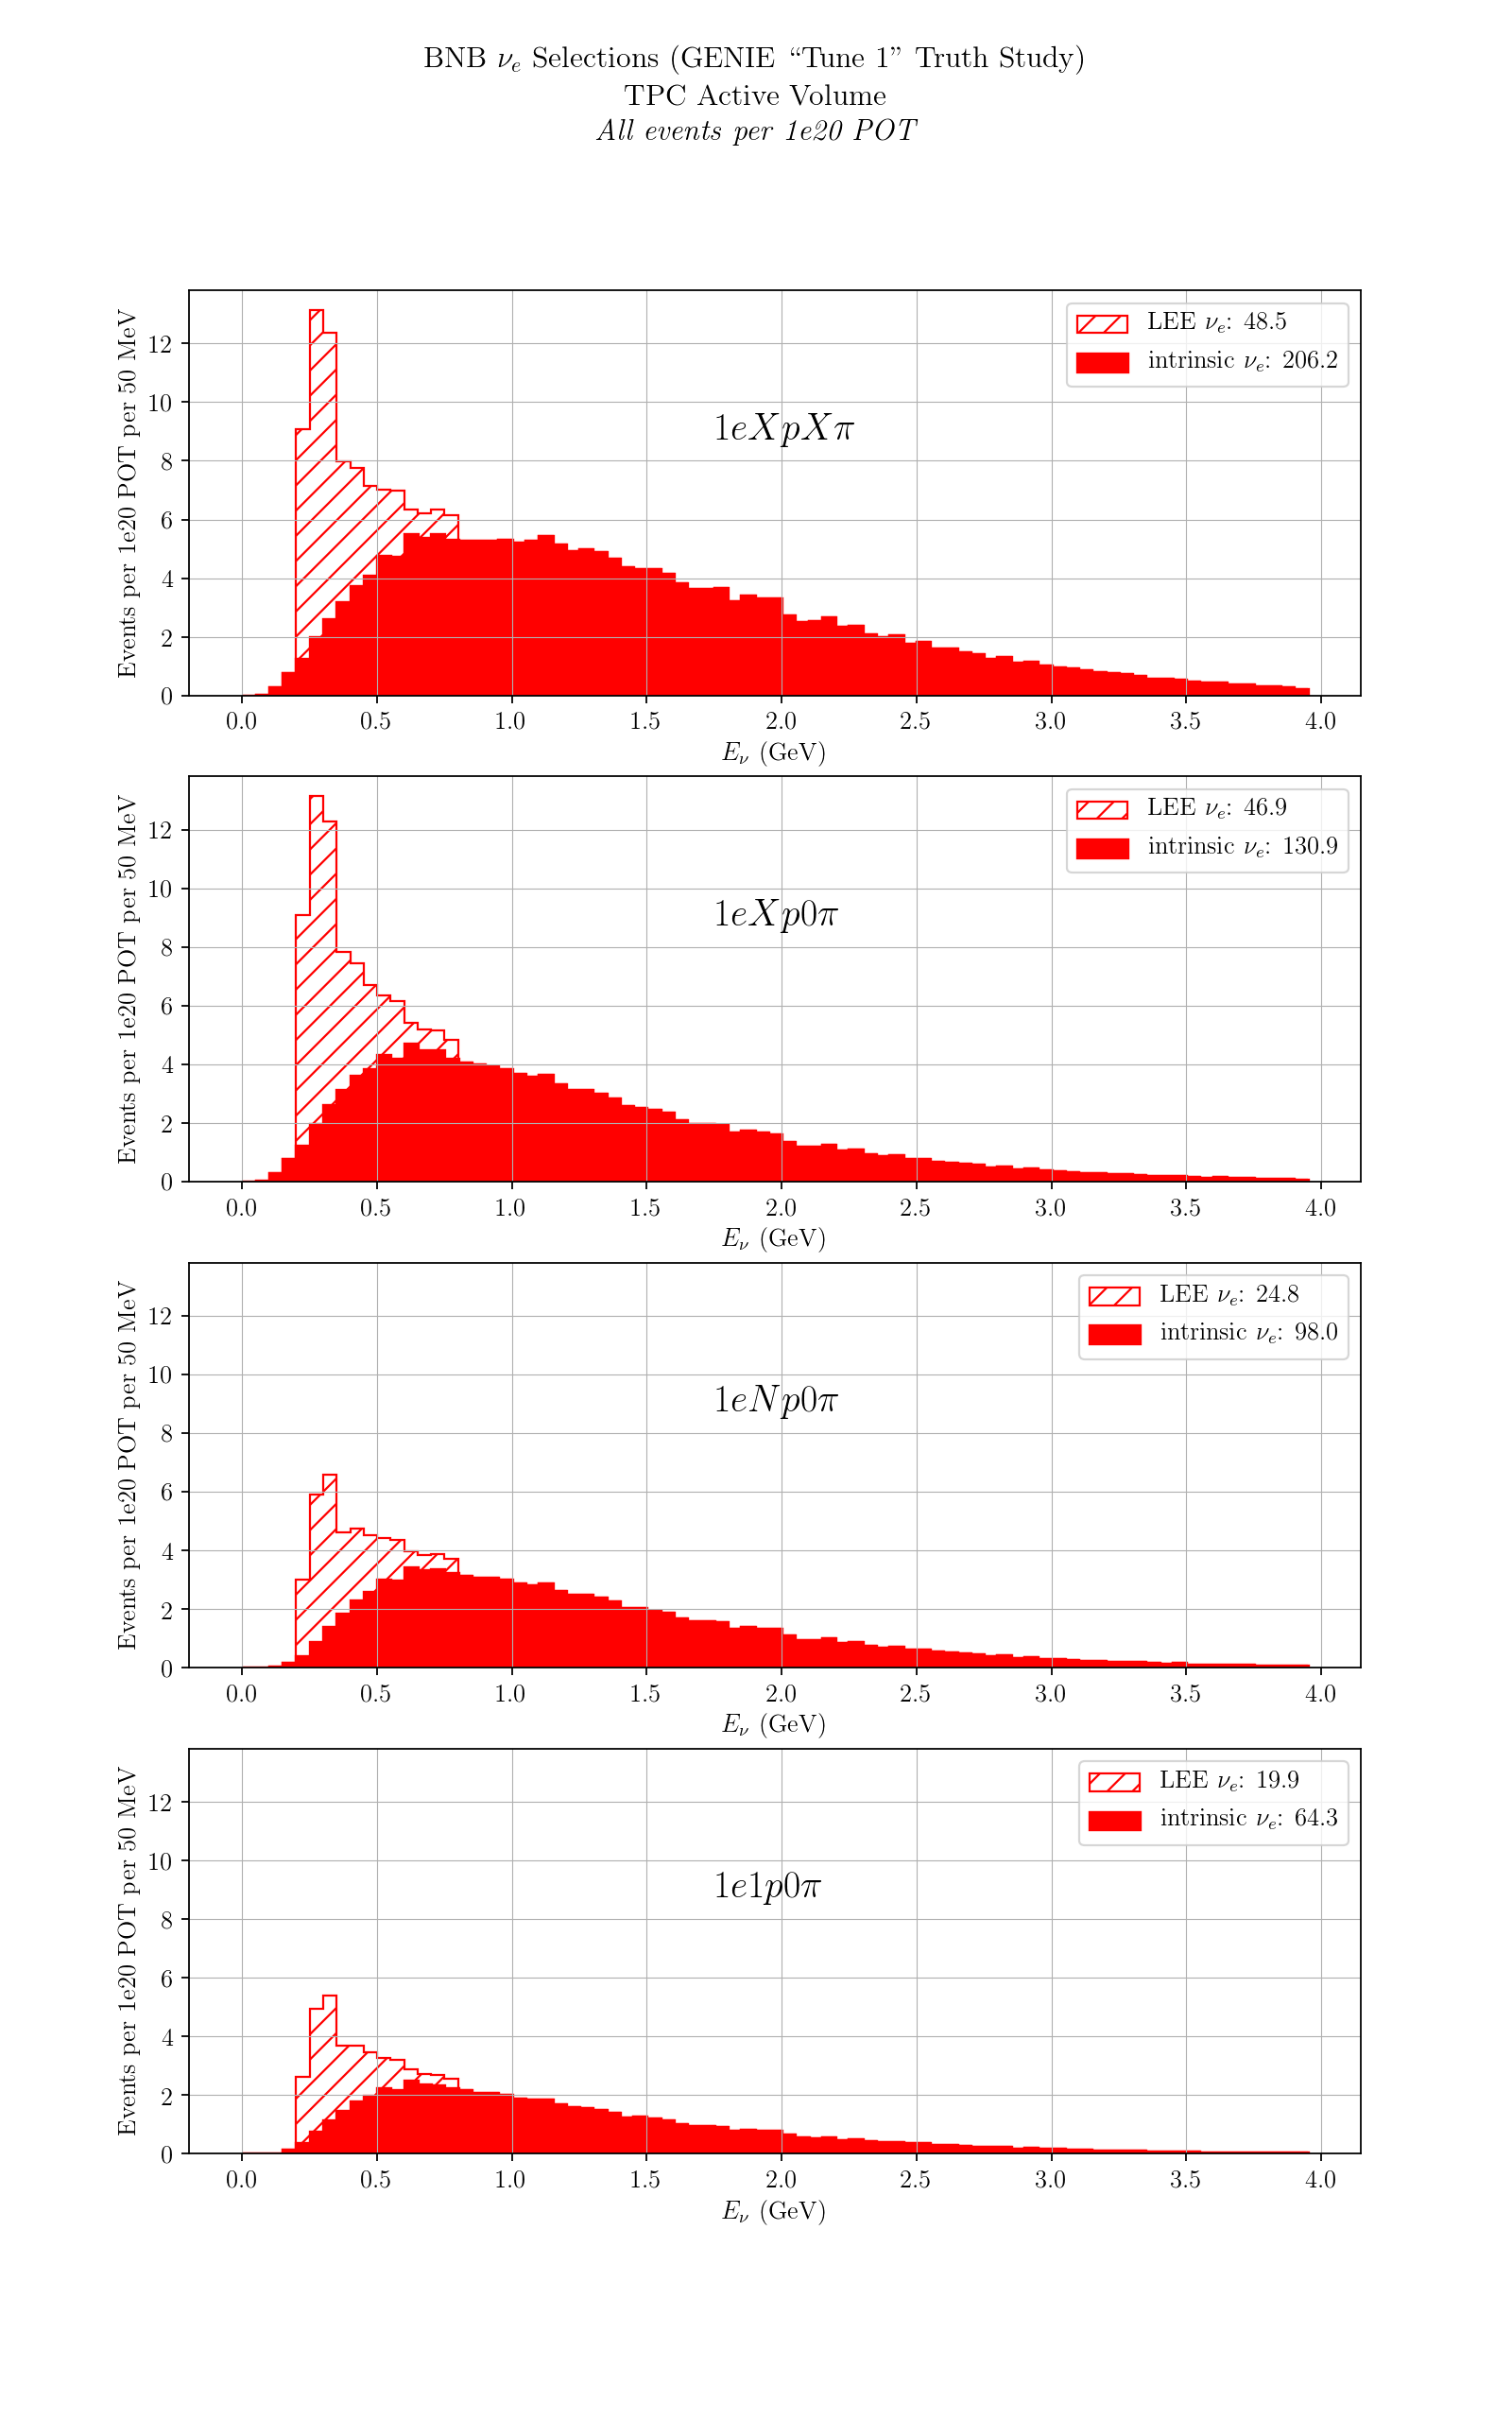

In [18]:
plt.rc('text', usetex=True)

hists_to_plot = [{'var':'e','cut':'1','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$','facecolor':'red','edgecolor':'red','fill':True, 'linewidth':1.5},
                 {'var':'e','cut':'1','weight':'lee_weight',
                  'label':'LEE $\\nu_e$','color':'red','hatch':'//','fill':False}
                 ]
df_selections = [df_1eXpXpi,
                 df_1eXp0pi,
                 df_1eNp0pi,
                 df_1e1p0pi]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,4.0,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],stacked=True)
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.45, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events_stacked.pdf")

<IPython.core.display.Javascript object>


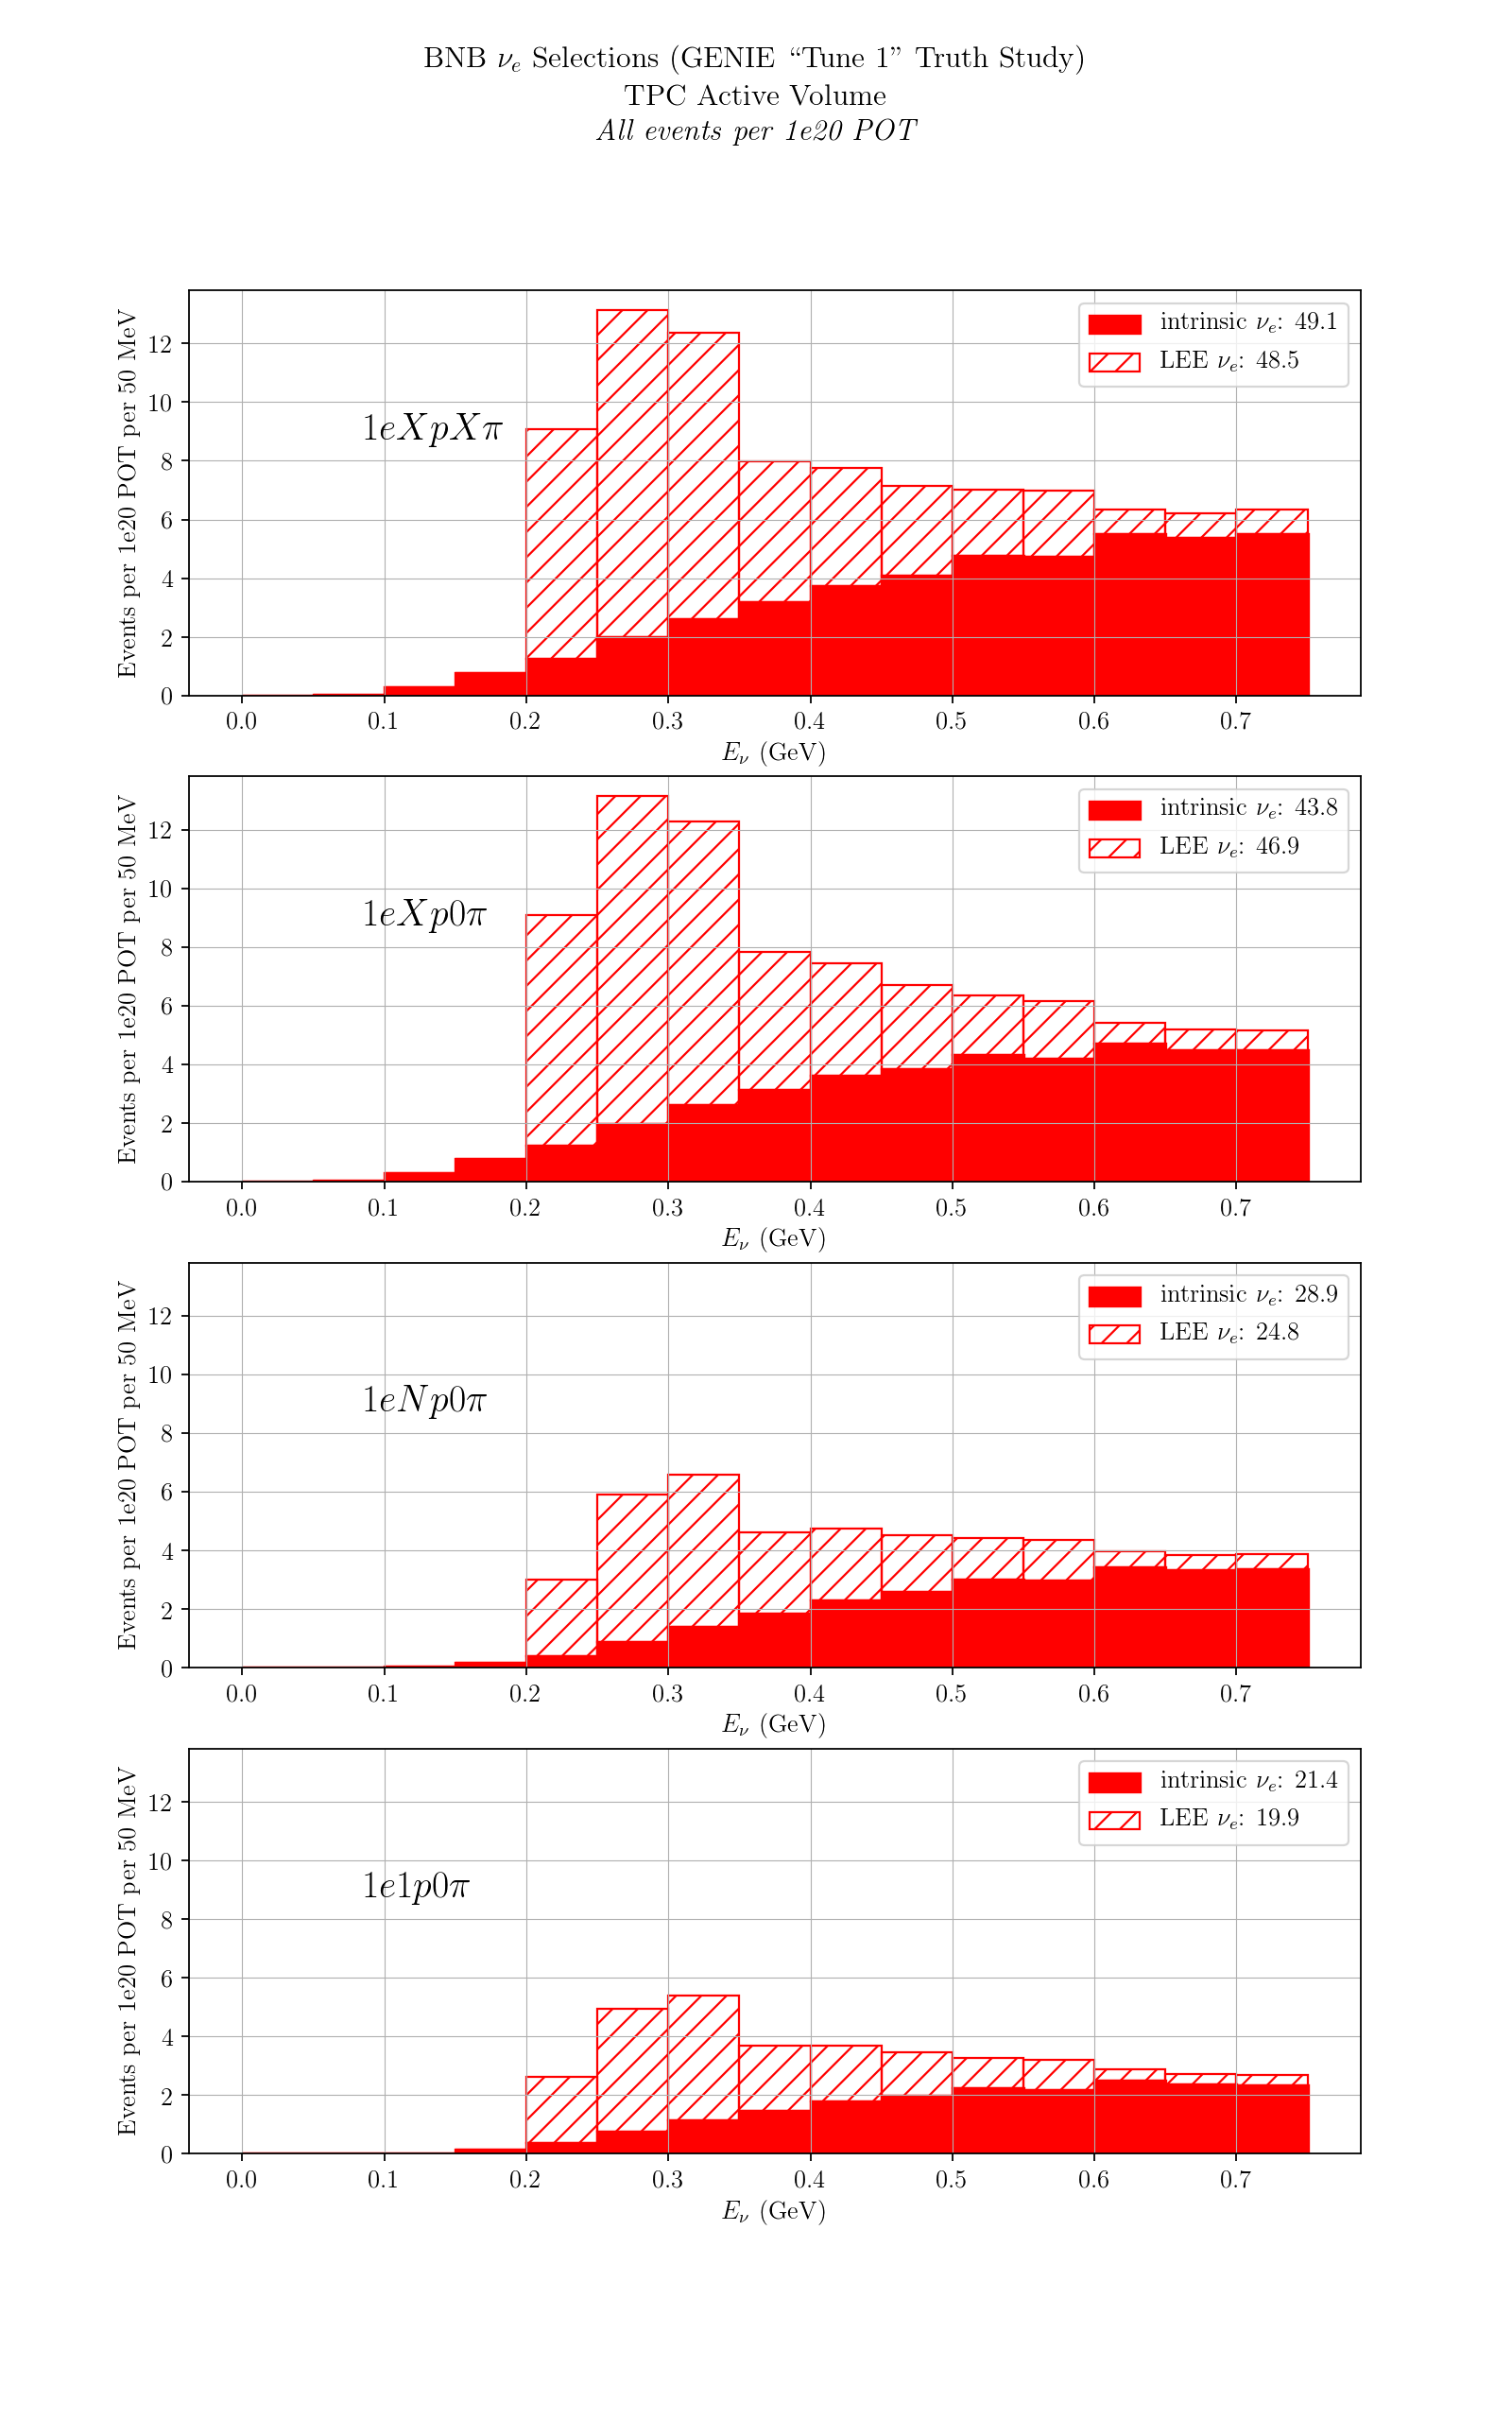

In [19]:
plt.rc('text', usetex=True)

hists_to_plot = [{'var':'e','cut':'1','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$','facecolor':'red','edgecolor':'red','fill':True, 'linewidth':1.5},
                 {'var':'e','cut':'1','weight':'lee_weight',
                  'label':'LEE $\\nu_e$','color':'red','hatch':'//','fill':False}
                 ]
df_selections = [df_1eXpXpi.query("e<0.8"),
                 df_1eXp0pi.query("e<0.8"),
                 df_1eNp0pi.query("e<0.8"),
                 df_1e1p0pi.query("e<0.8")]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,0.8,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],stacked=True,histtype="bar")
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.15, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events_zoom_stacked.pdf")

<IPython.core.display.Javascript object>


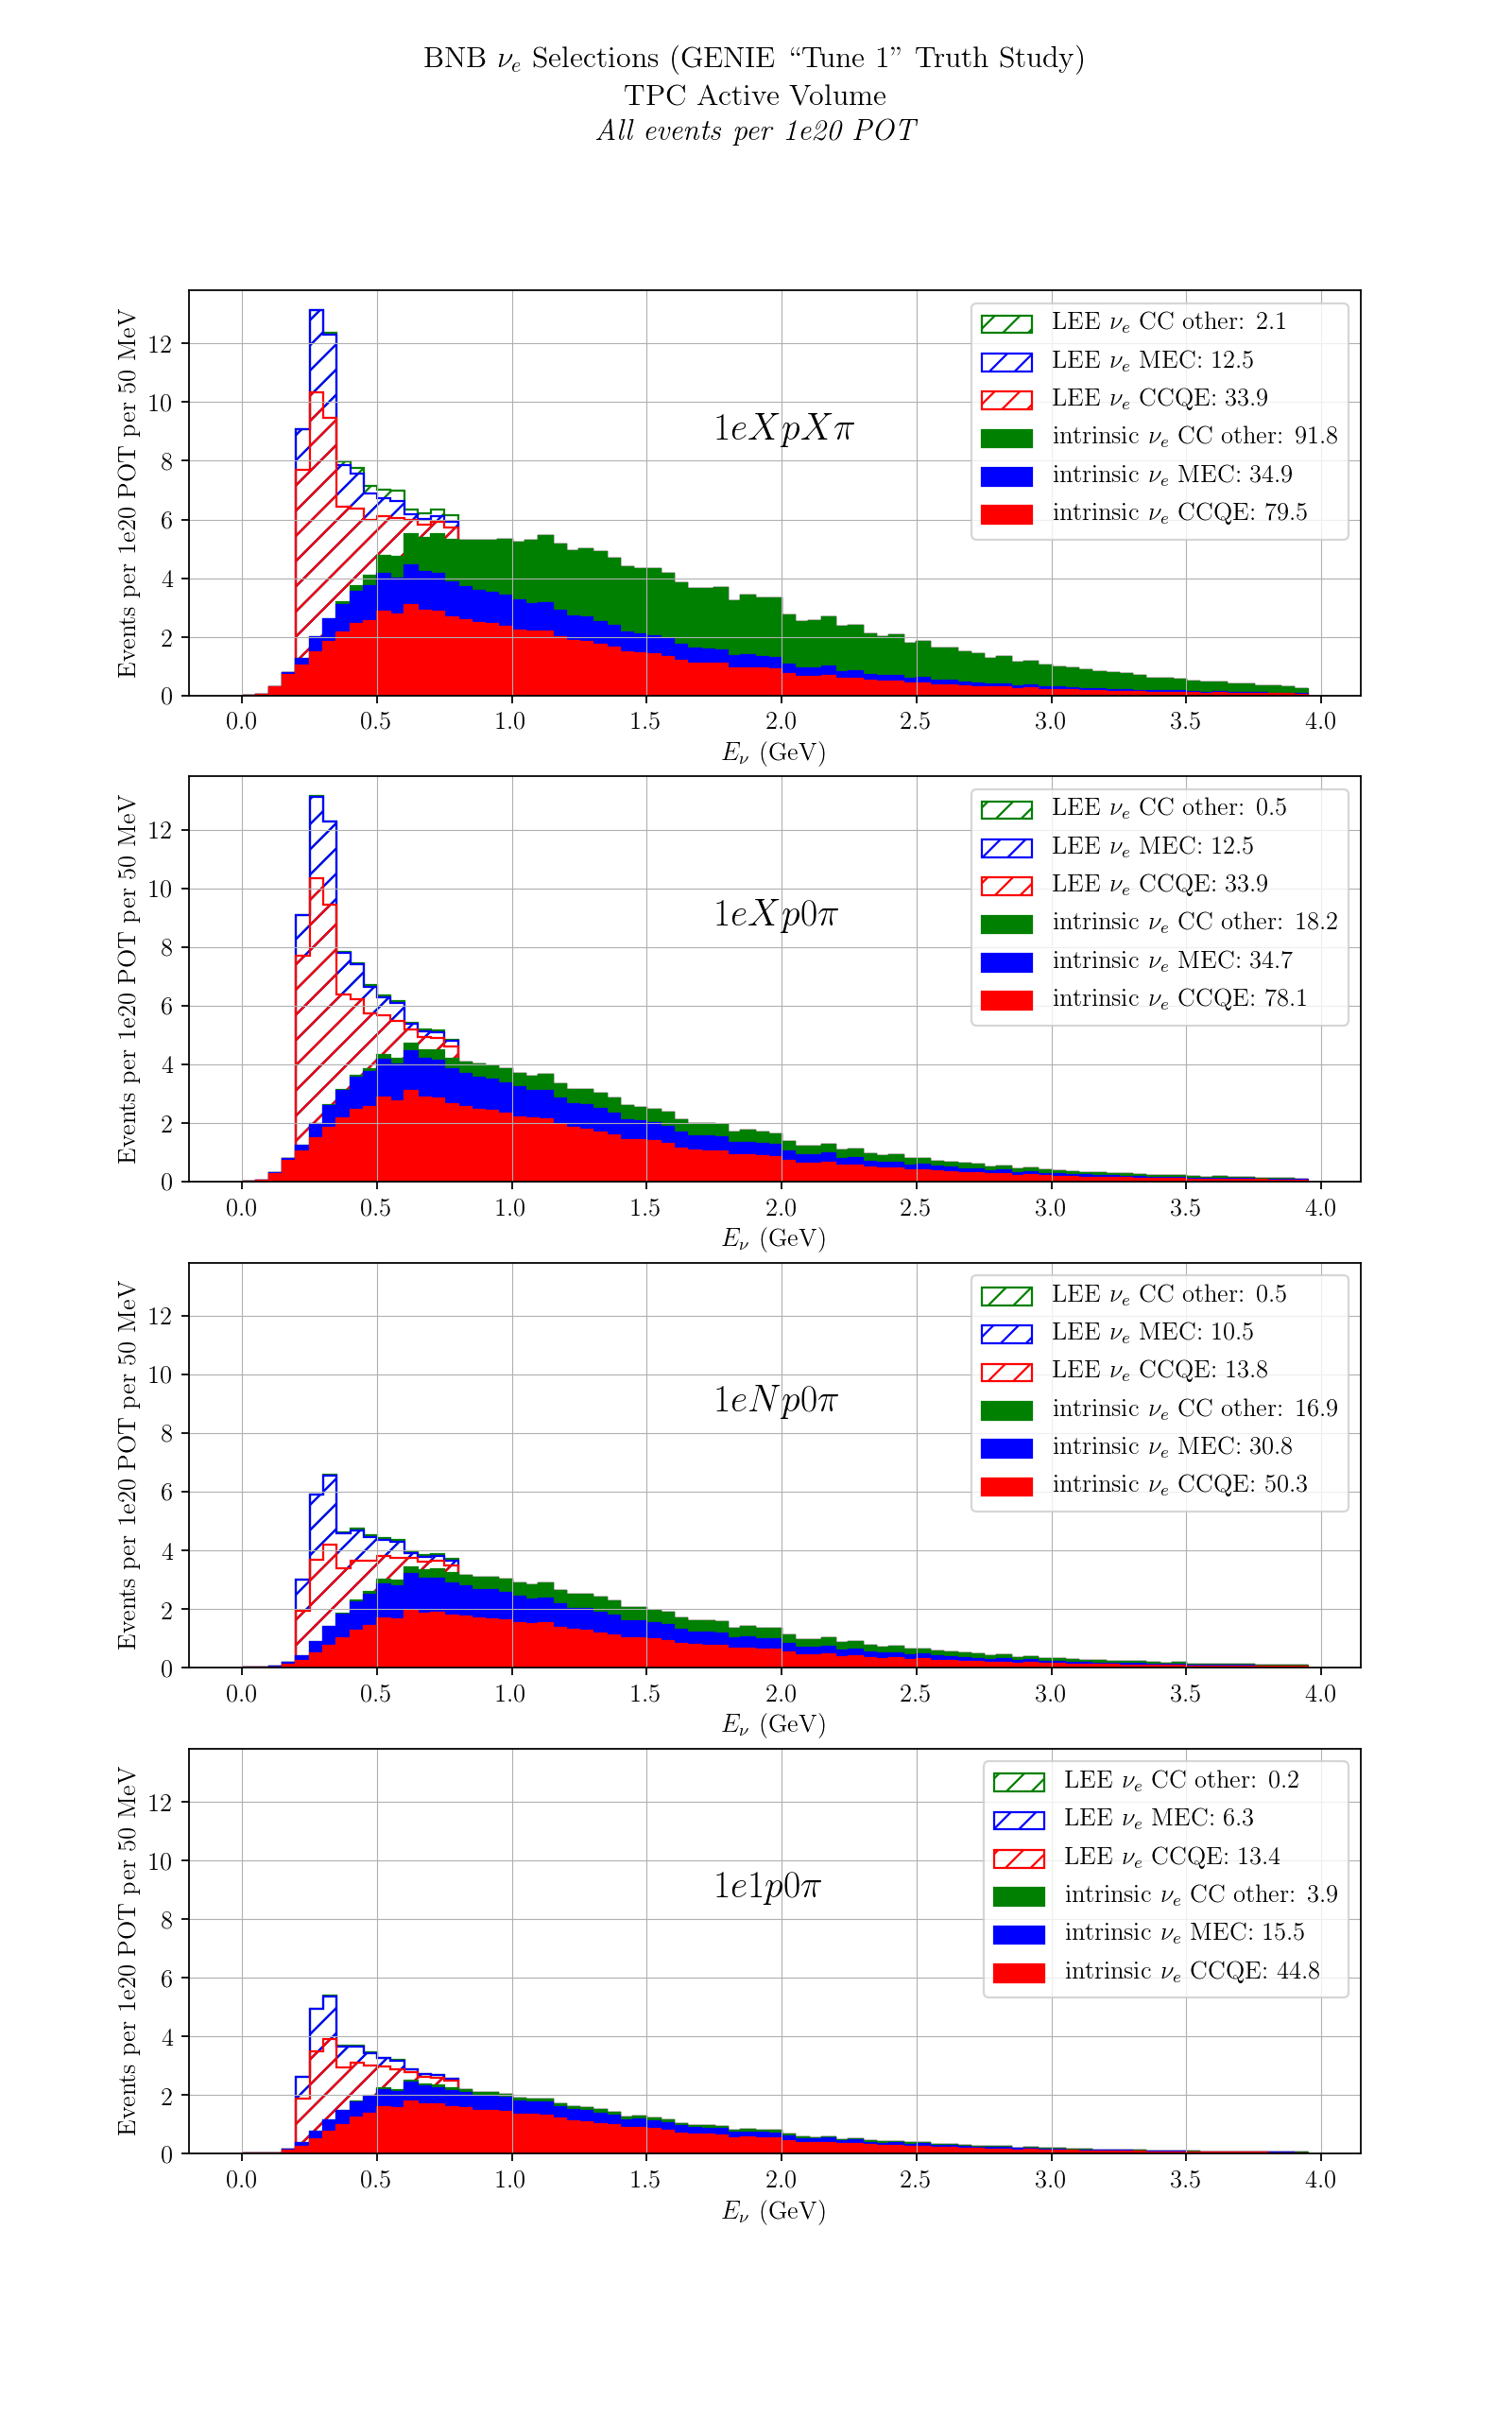

In [20]:
hists_to_plot = [{'var':'e','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'e','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'e','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1eXpXpi,
                 df_1eXp0pi,
                 df_1eNp0pi,
                 df_1e1p0pi]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,4.0,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i])
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.45, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events_stacked_inttype.pdf")

<IPython.core.display.Javascript object>


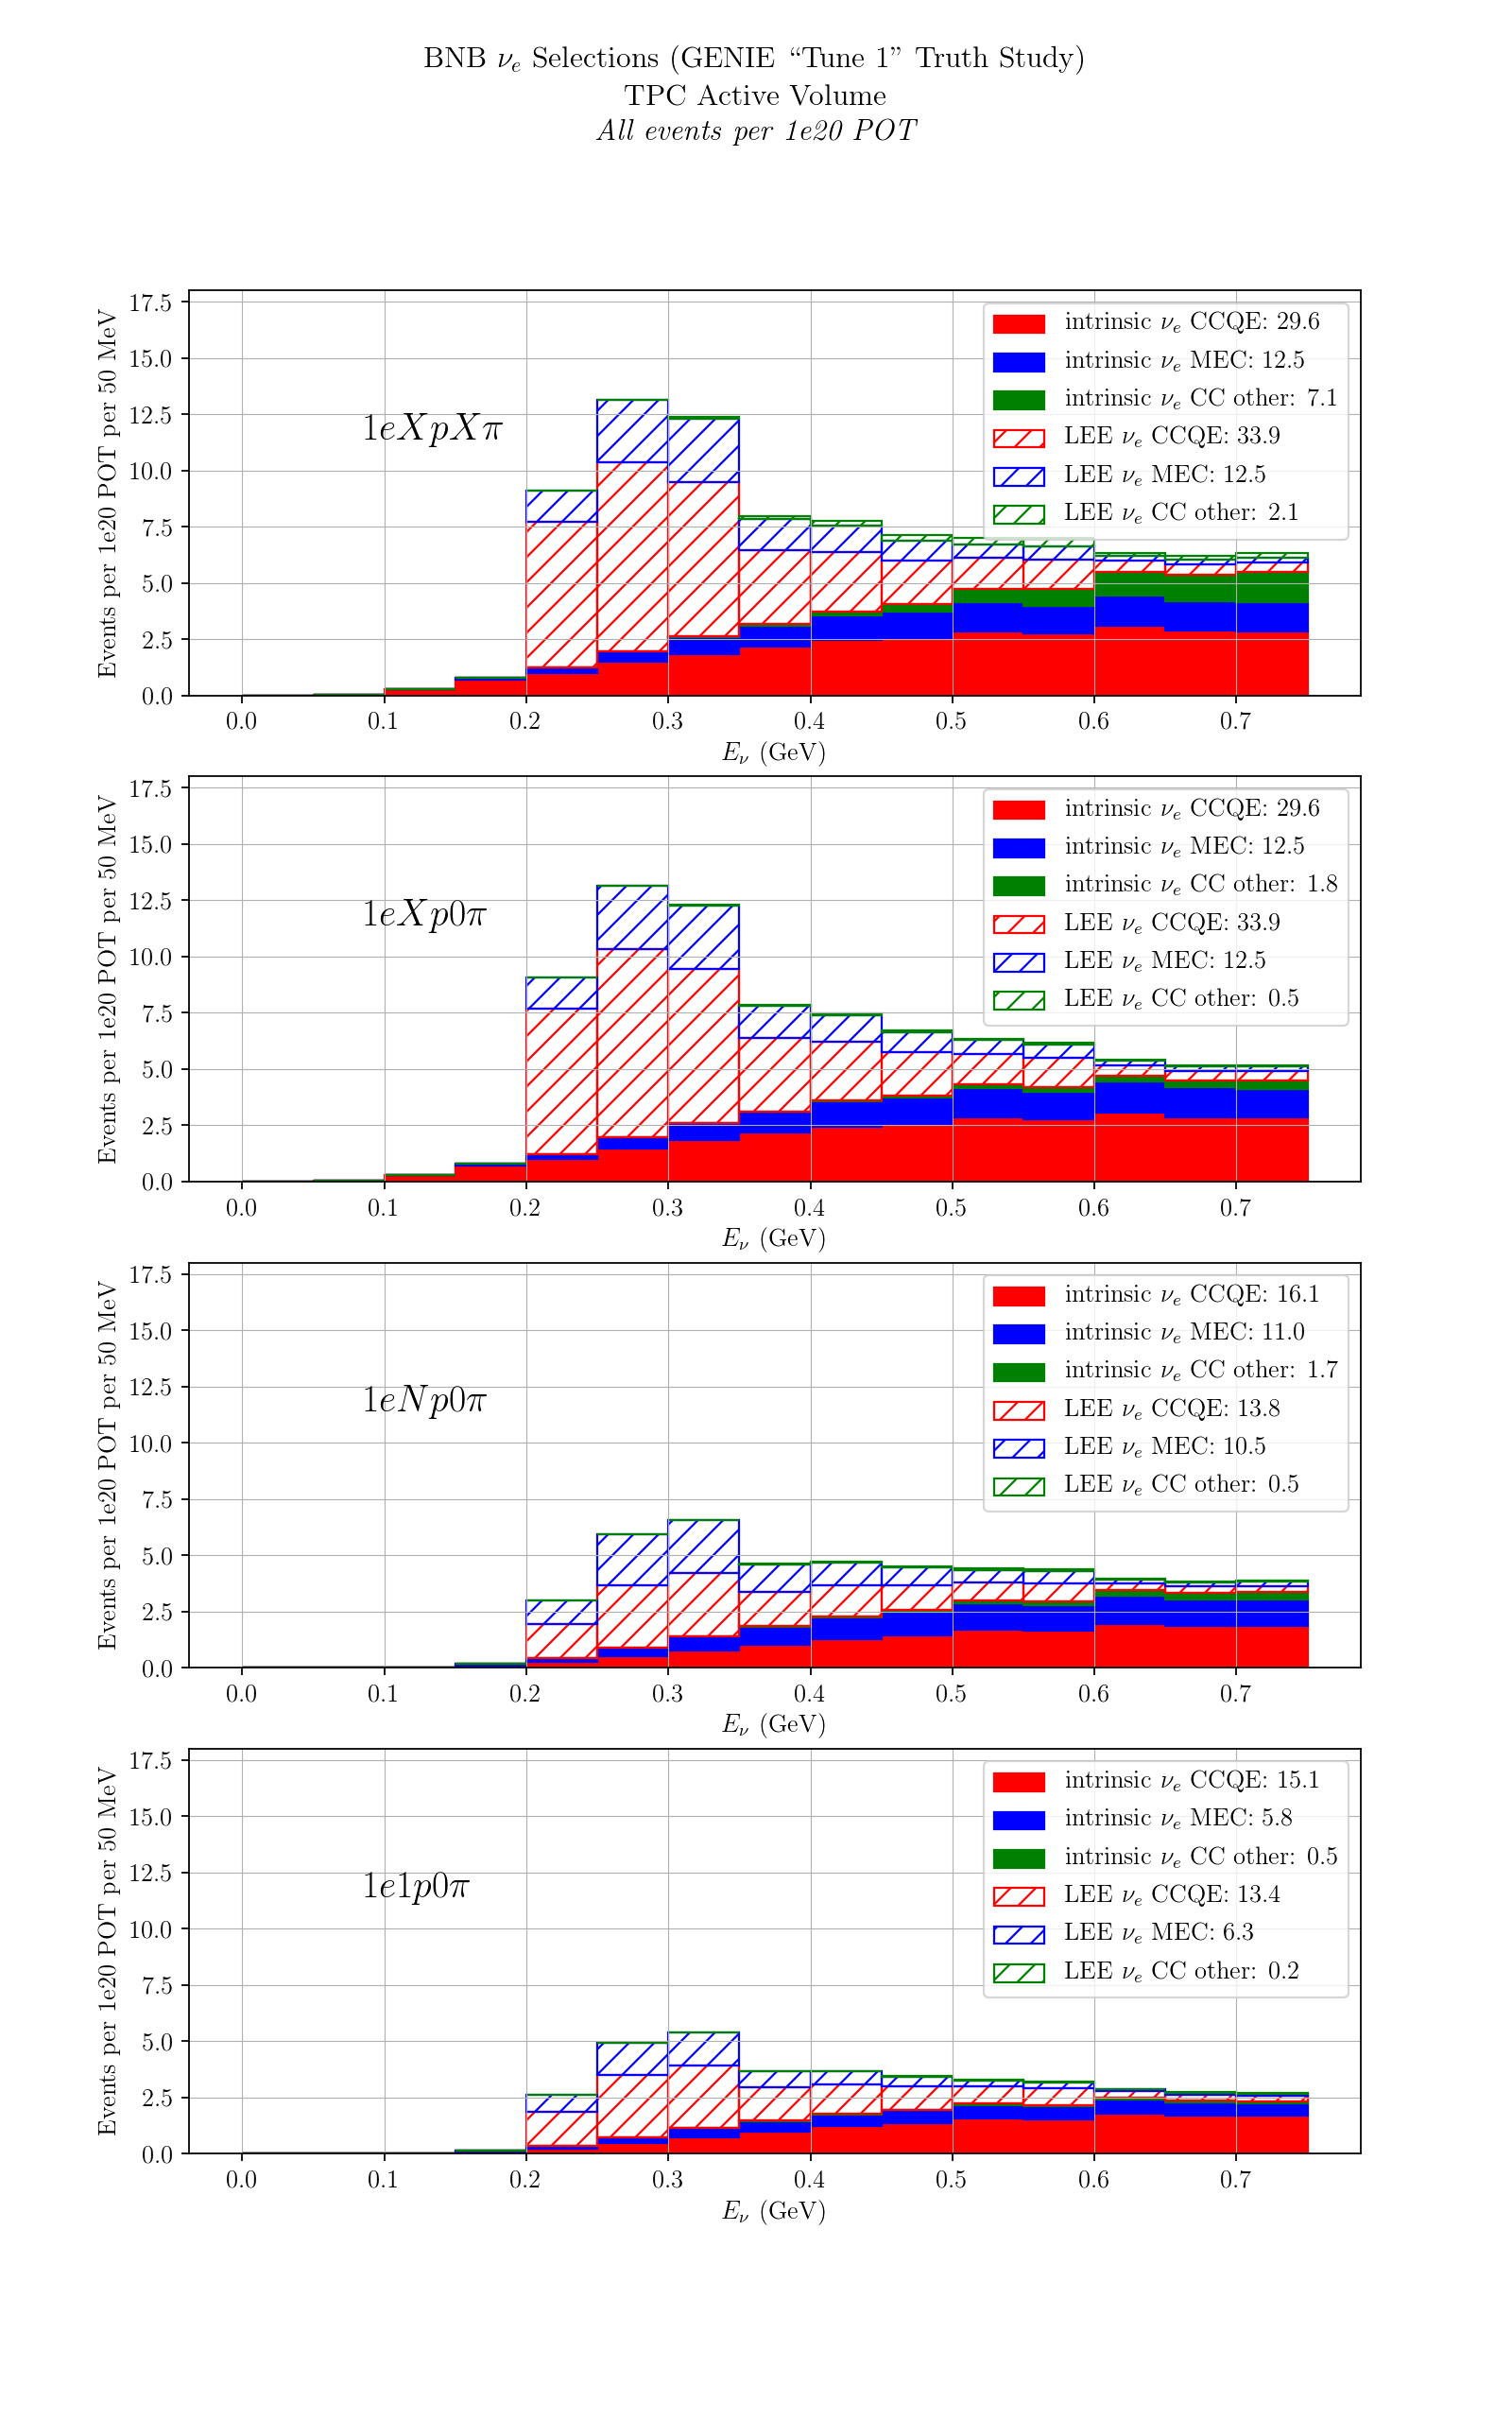

In [21]:
hists_to_plot = [{'var':'e','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'e','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'e','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1eXpXpi.query("e<0.8"),
                 df_1eXp0pi.query("e<0.8"),
                 df_1eNp0pi.query("e<0.8"),
                 df_1e1p0pi.query("e<0.8")]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,0.8,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],histtype='bar')
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.15, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].set_ylim(0.0,18.)
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_energy_events_stacked_zoom_inttype.pdf")

<IPython.core.display.Javascript object>


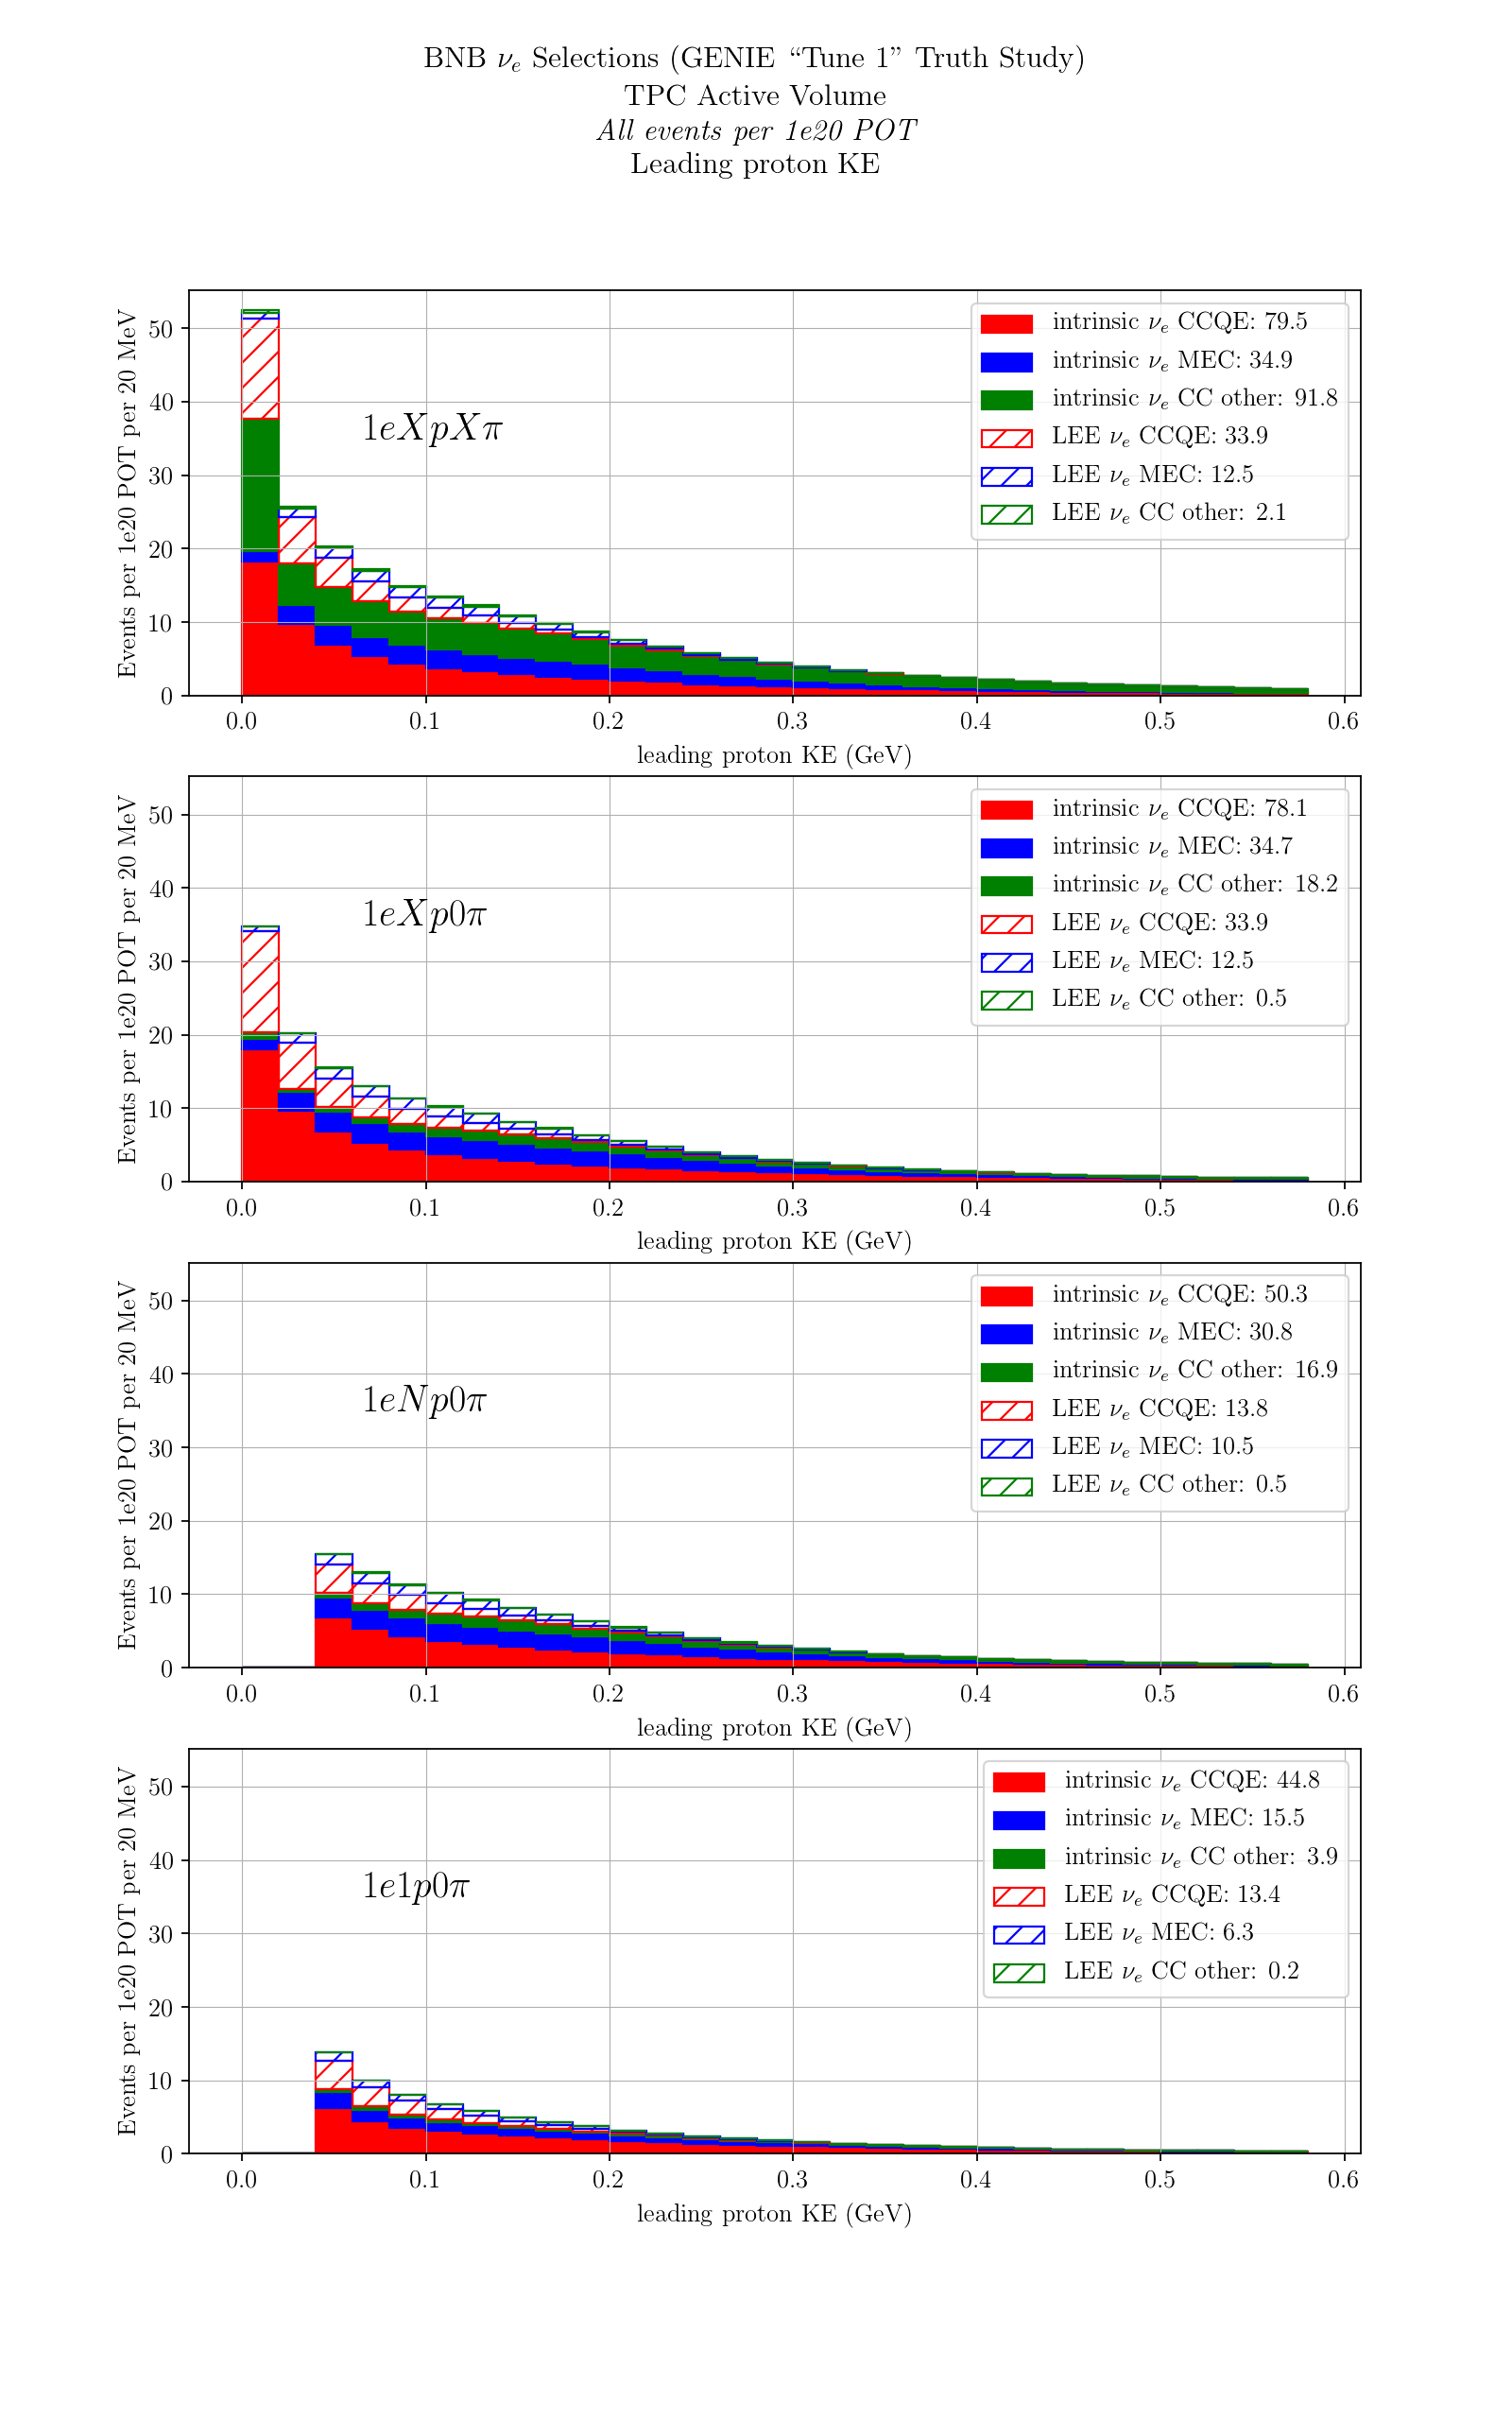

In [22]:
hists_to_plot = [{'var':'ke_p1','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'ke_p1','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'ke_p1','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'ke_p1','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'ke_p1','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'ke_p1','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1eXpXpi.fillna(0),
                 df_1eXp0pi.fillna(0),
                 df_1eNp0pi.fillna(0),
                 df_1e1p0pi.fillna(0)]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_ke = np.arange(0,0.6,0.02)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_ke,axis=ax[i],histtype="bar")
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.15, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("leading proton KE (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 20 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}\nLeading proton KE")
plt.show()
plt.savefig("plots/nue_selections_p1_ke_events_stacked_zoom_inttype.pdf")

<IPython.core.display.Javascript object>


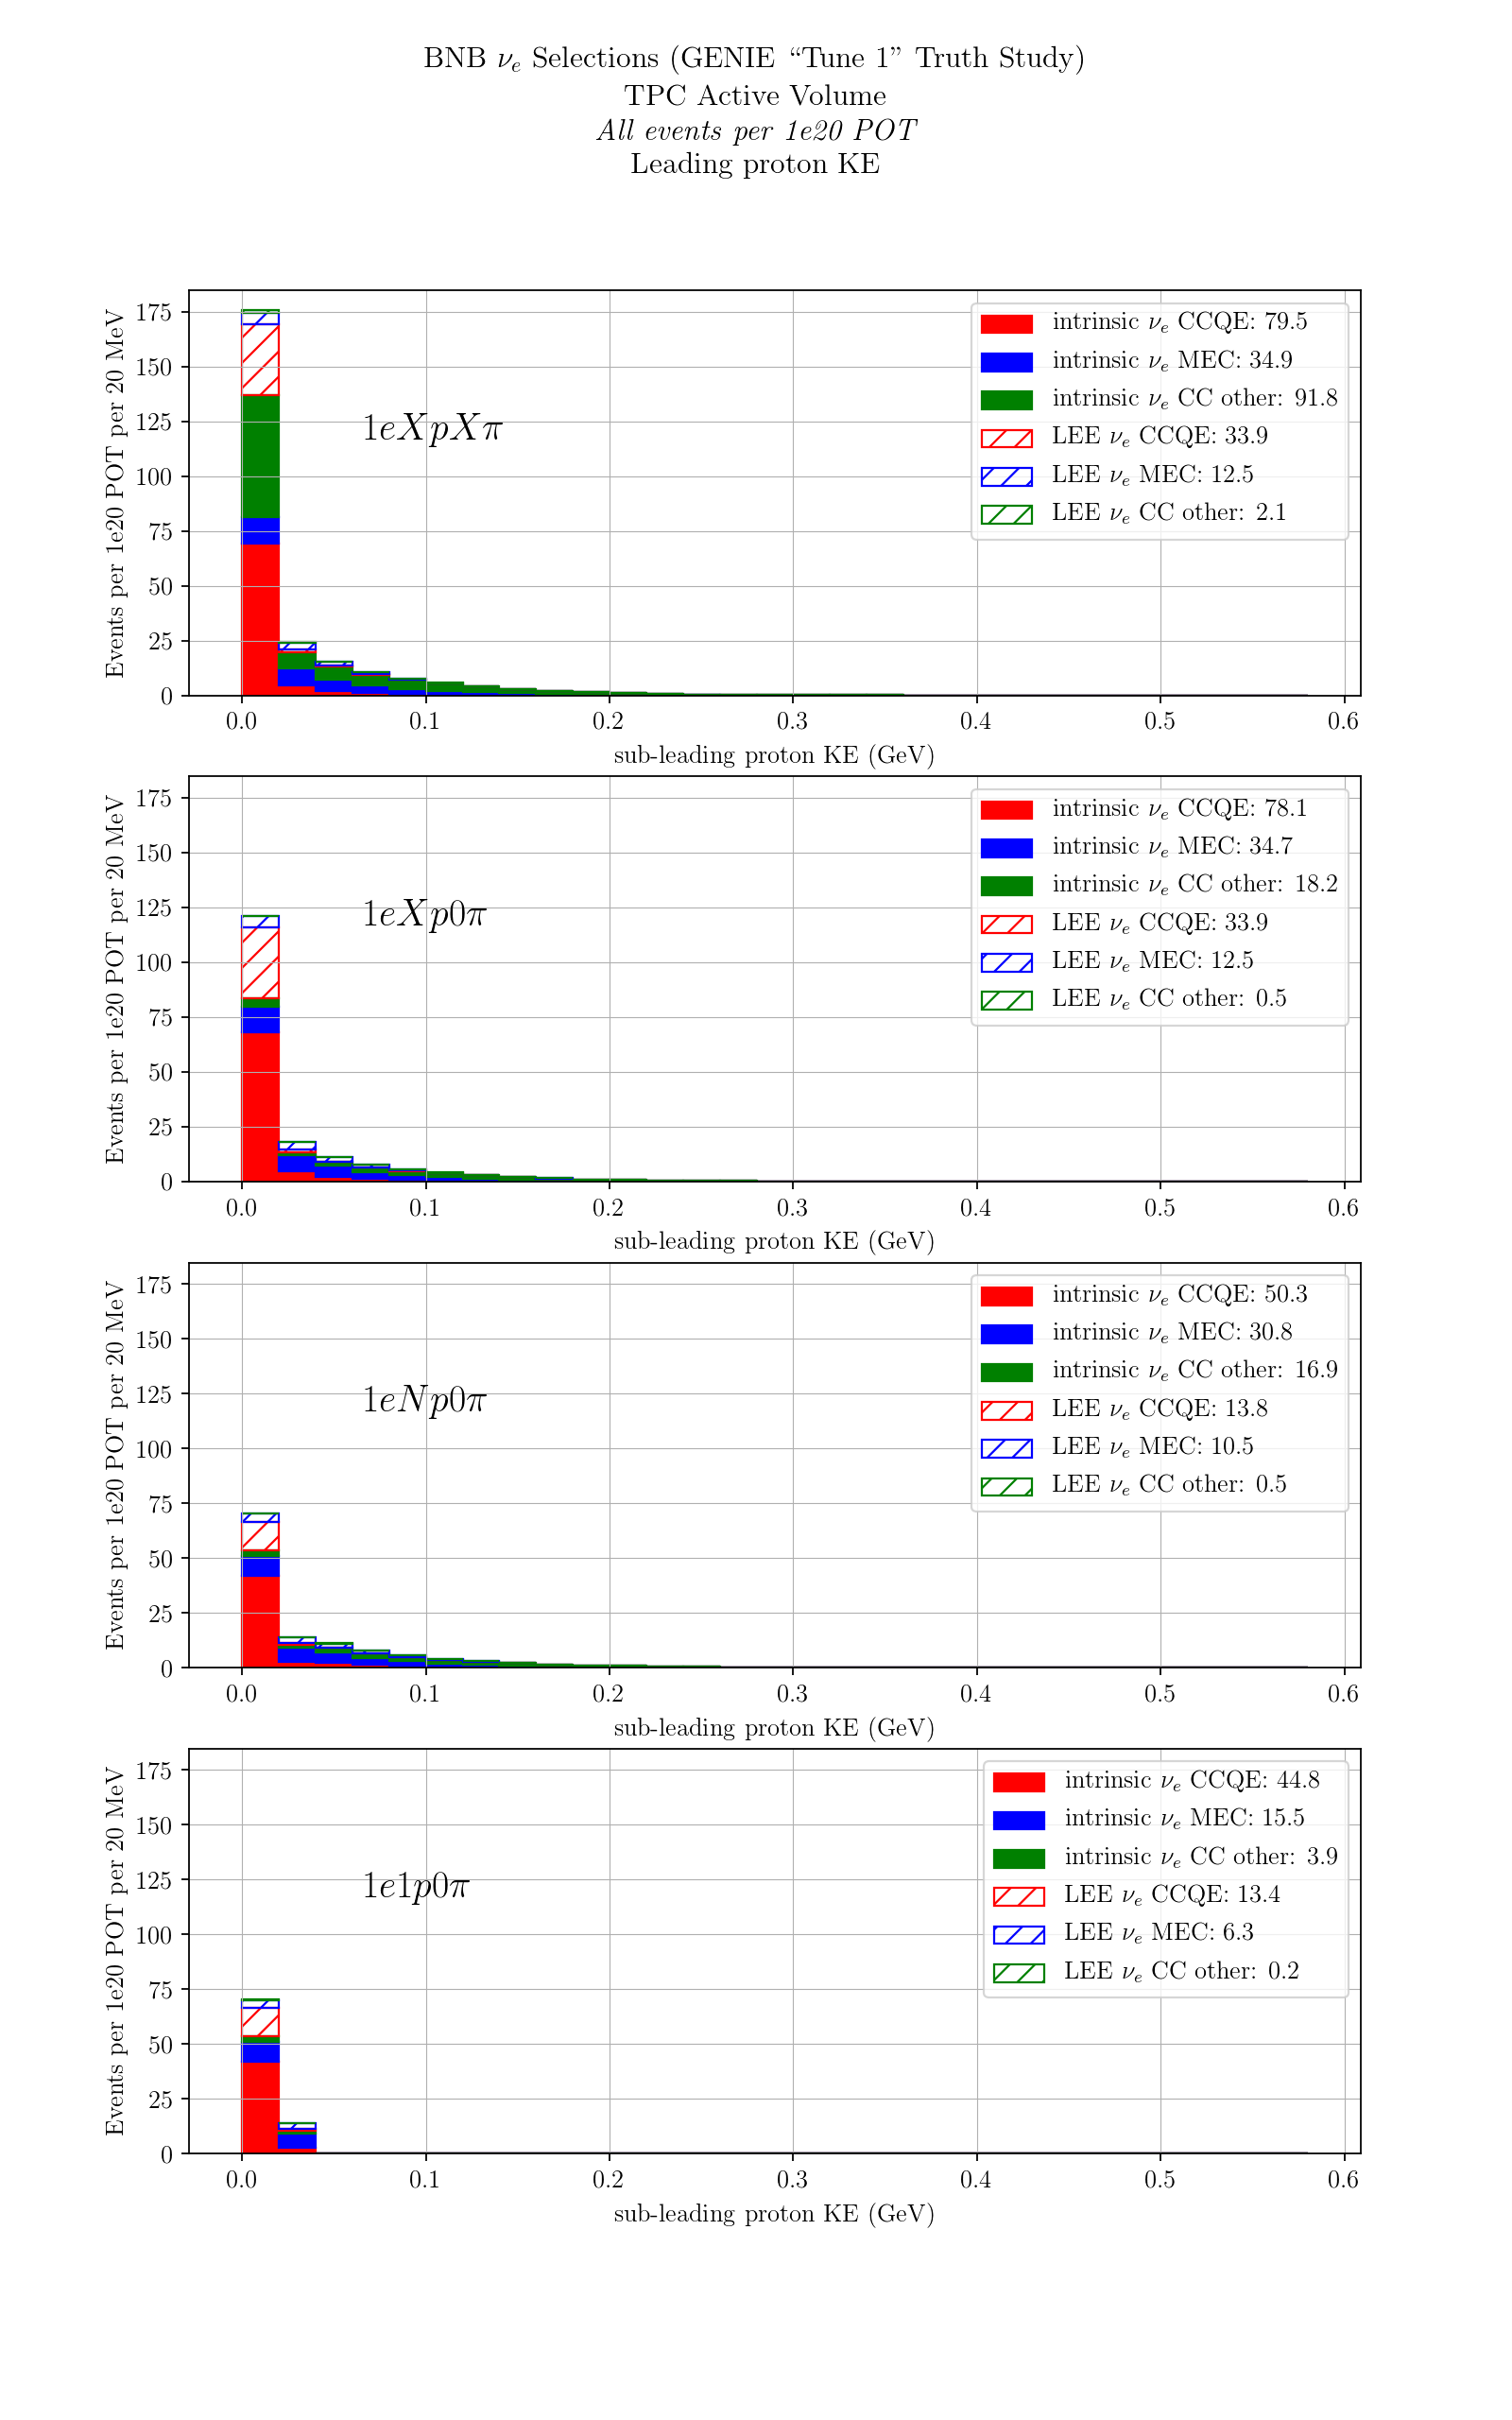

In [23]:
hists_to_plot = [{'var':'ke_p2','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'ke_p2','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'ke_p2','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'ke_p2','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'ke_p2','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'ke_p2','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1eXpXpi.fillna(0),
                 df_1eXp0pi.fillna(0),
                 df_1eNp0pi.fillna(0),
                 df_1e1p0pi.fillna(0)]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_ke = np.arange(0,0.6,0.02)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,16.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_ke,axis=ax[i],histtype="bar")
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.15, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("sub-leading proton KE (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 20 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}\nLeading proton KE")
plt.show()
plt.savefig("plots/nue_selections_p2_ke_events_stacked_zoom_inttype.pdf")

<IPython.core.display.Javascript object>


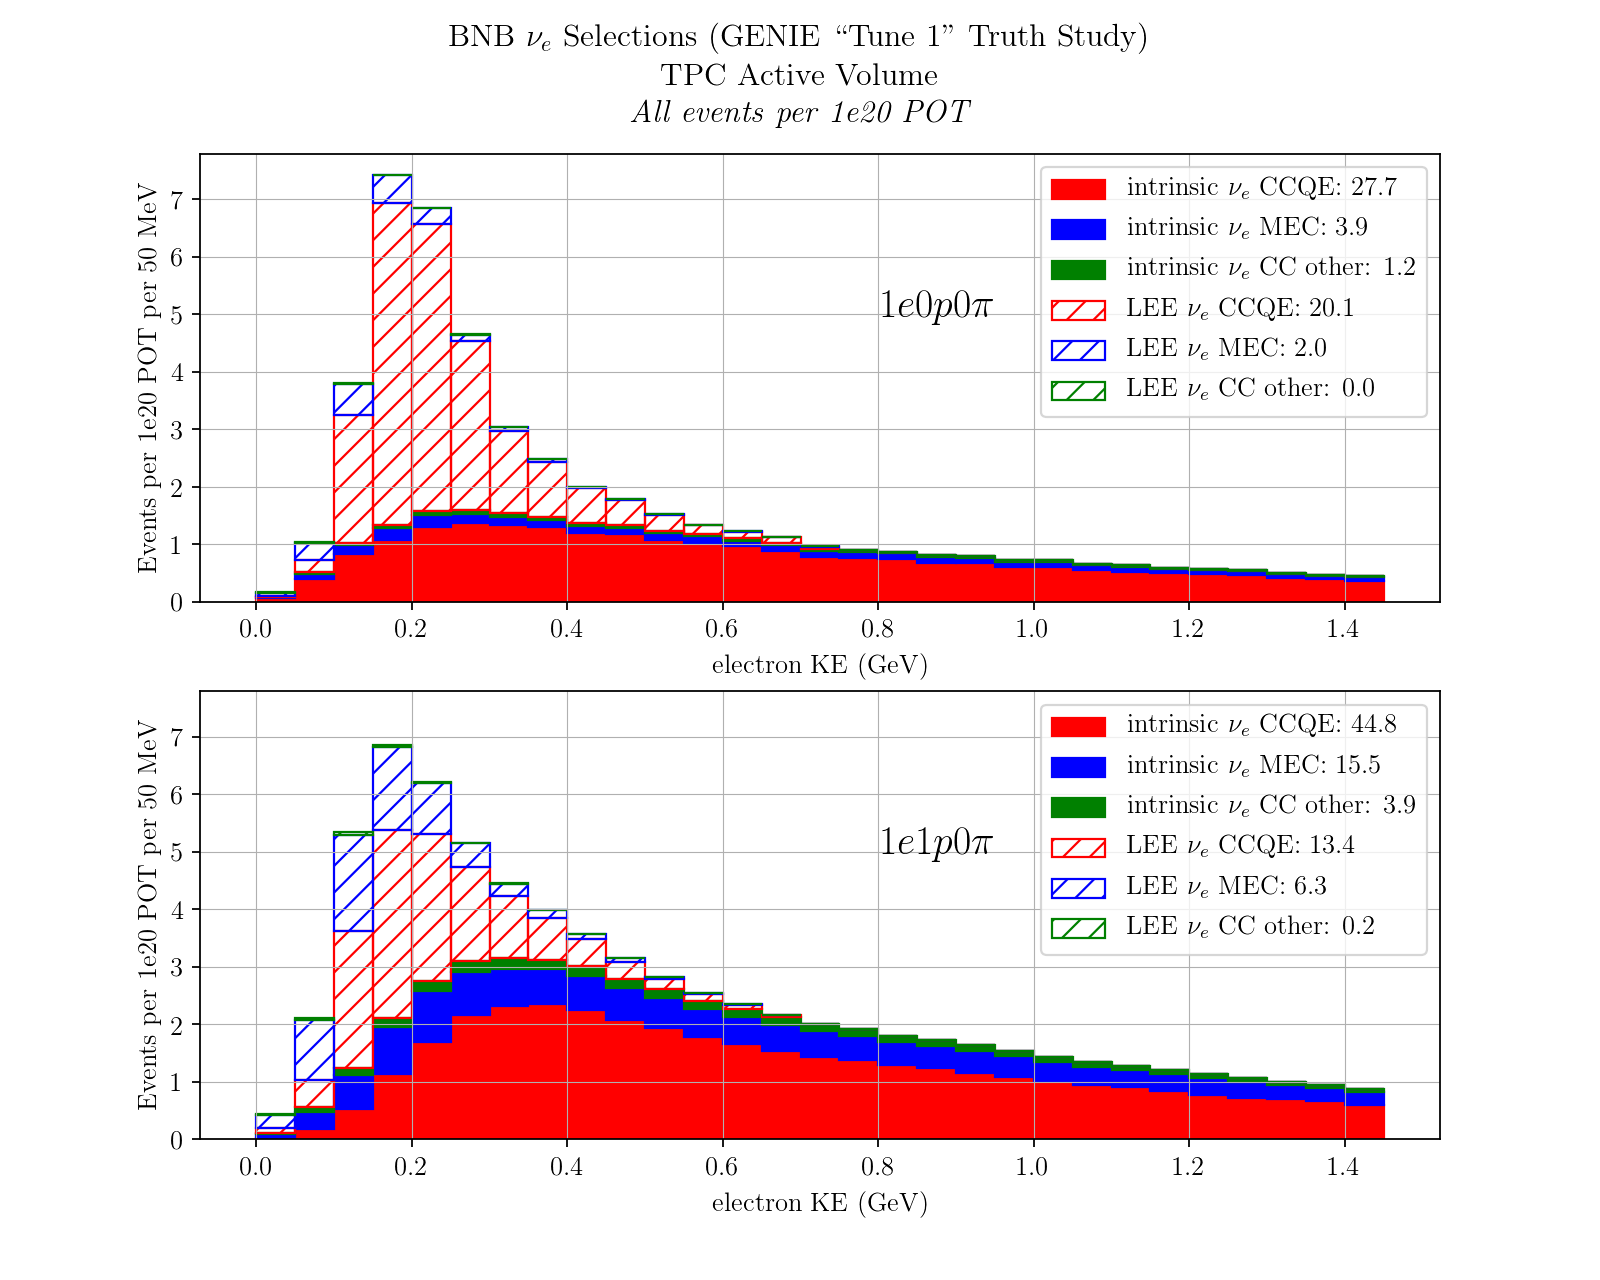

In [24]:
hists_to_plot = [{'var':'ke_e','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'ke_e','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'ke_e','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'ke_e','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'ke_e','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'ke_e','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1e0p0pi.fillna(0),
                 df_1e1p0pi.fillna(0)]
sel_labels = ["$1e 0p 0\pi$","$1e 1p 0\pi$" ]

bins_ke = np.arange(0,1.5,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,8.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_ke,axis=ax[i],histtype="bar")
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.55, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("electron KE (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_selections_ke_electron_events_stacked_inttype_0pvs1p.pdf")

<IPython.core.display.Javascript object>


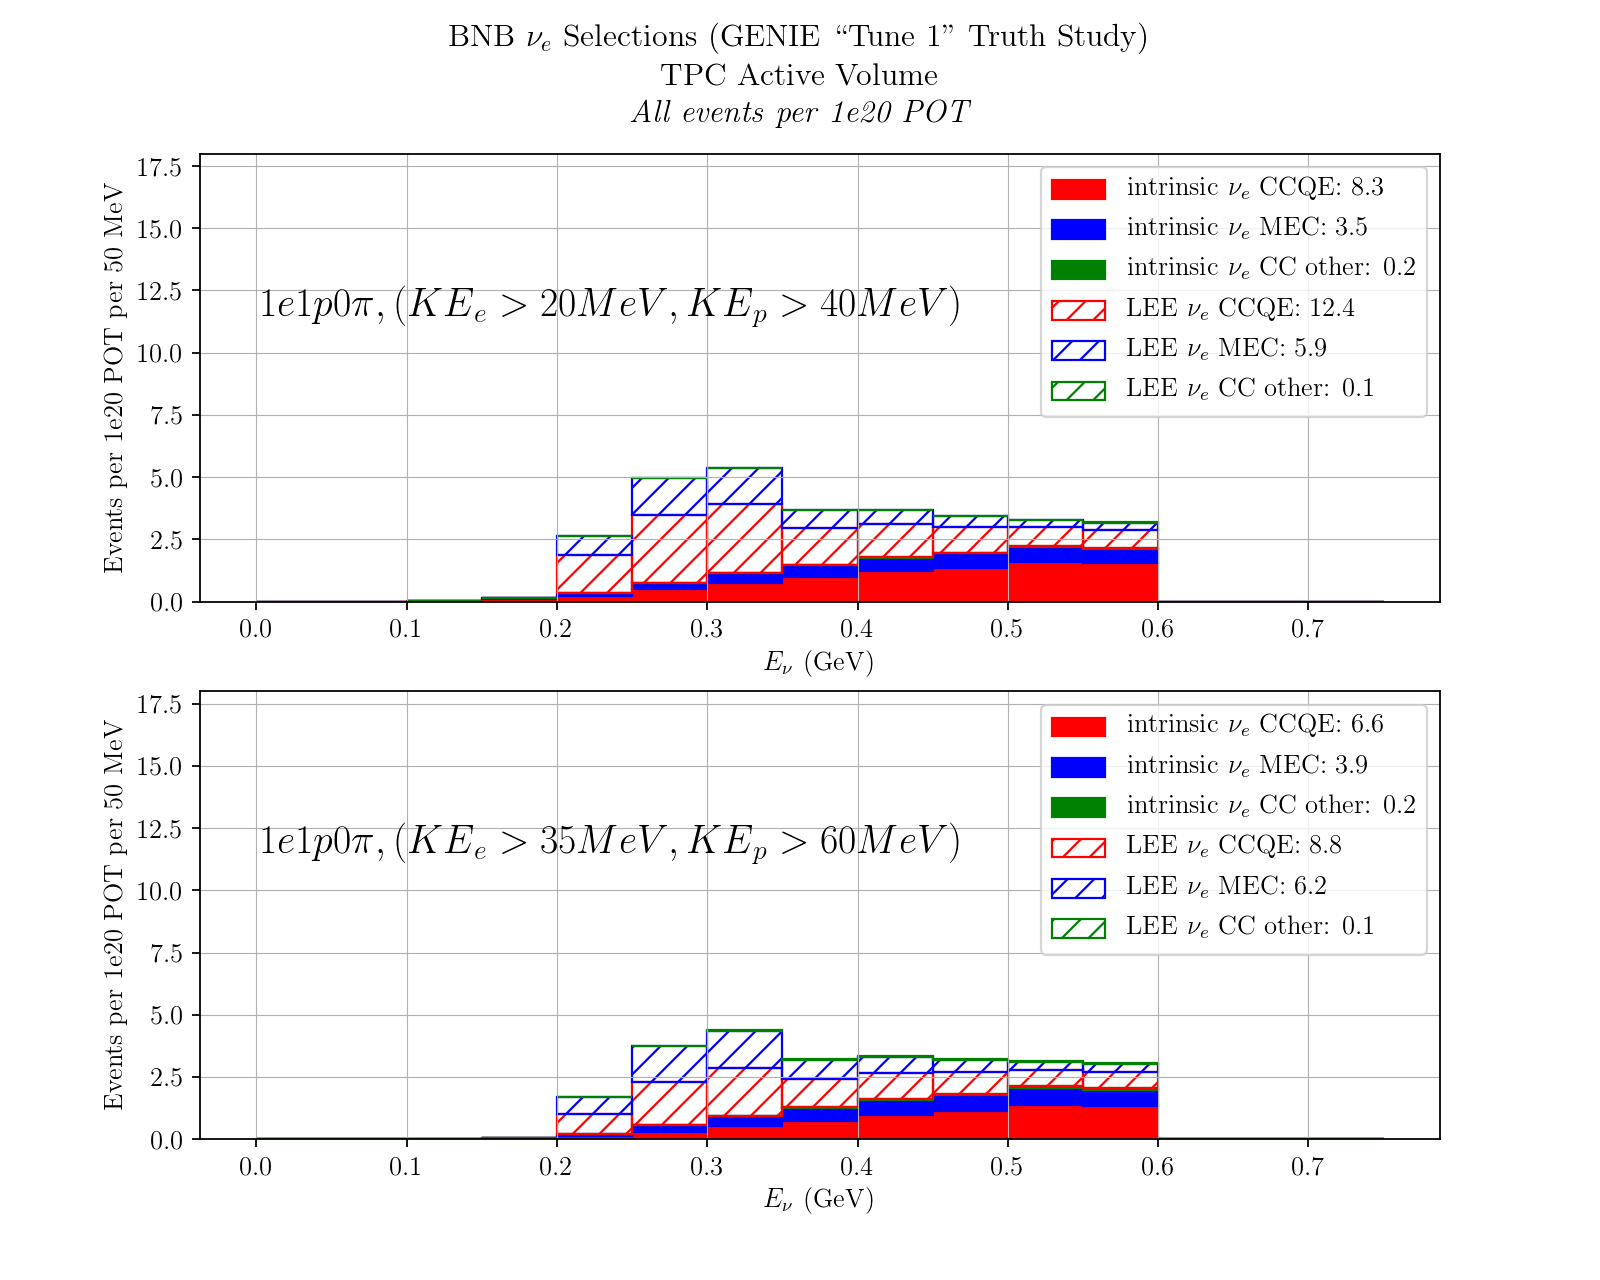

In [25]:
hists_to_plot = [{'var':'e','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'e','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'e','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1e1p0pi.query("e<0.6"),
                 df_1e1p0pi_DL.query("e<0.6")]
sel_labels = ["$1e 1p 0\pi, (\mathnormal{KE}_e>20\mathnormal{MeV},\mathnormal{KE}_p>40\mathnormal{MeV})$",
              "$1e 1p 0\pi, (\mathnormal{KE}_e>35\mathnormal{MeV},\mathnormal{KE}_p>60\mathnormal{MeV})$"]

bins_energy = np.arange(0,0.8,0.05)

fig,ax = plt.subplots(len(df_selections),sharey='all',figsize=(10.0,8.0))
for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i],histtype='bar')
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].text(0.05, 0.7, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)")
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV")
    ax[i].set_ylim(0.0,18.)
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}")
plt.show()
plt.savefig("plots/nue_1e1p_energy_events_stacked_zoom_inttype_DLcomp.pdf")

<IPython.core.display.Javascript object>


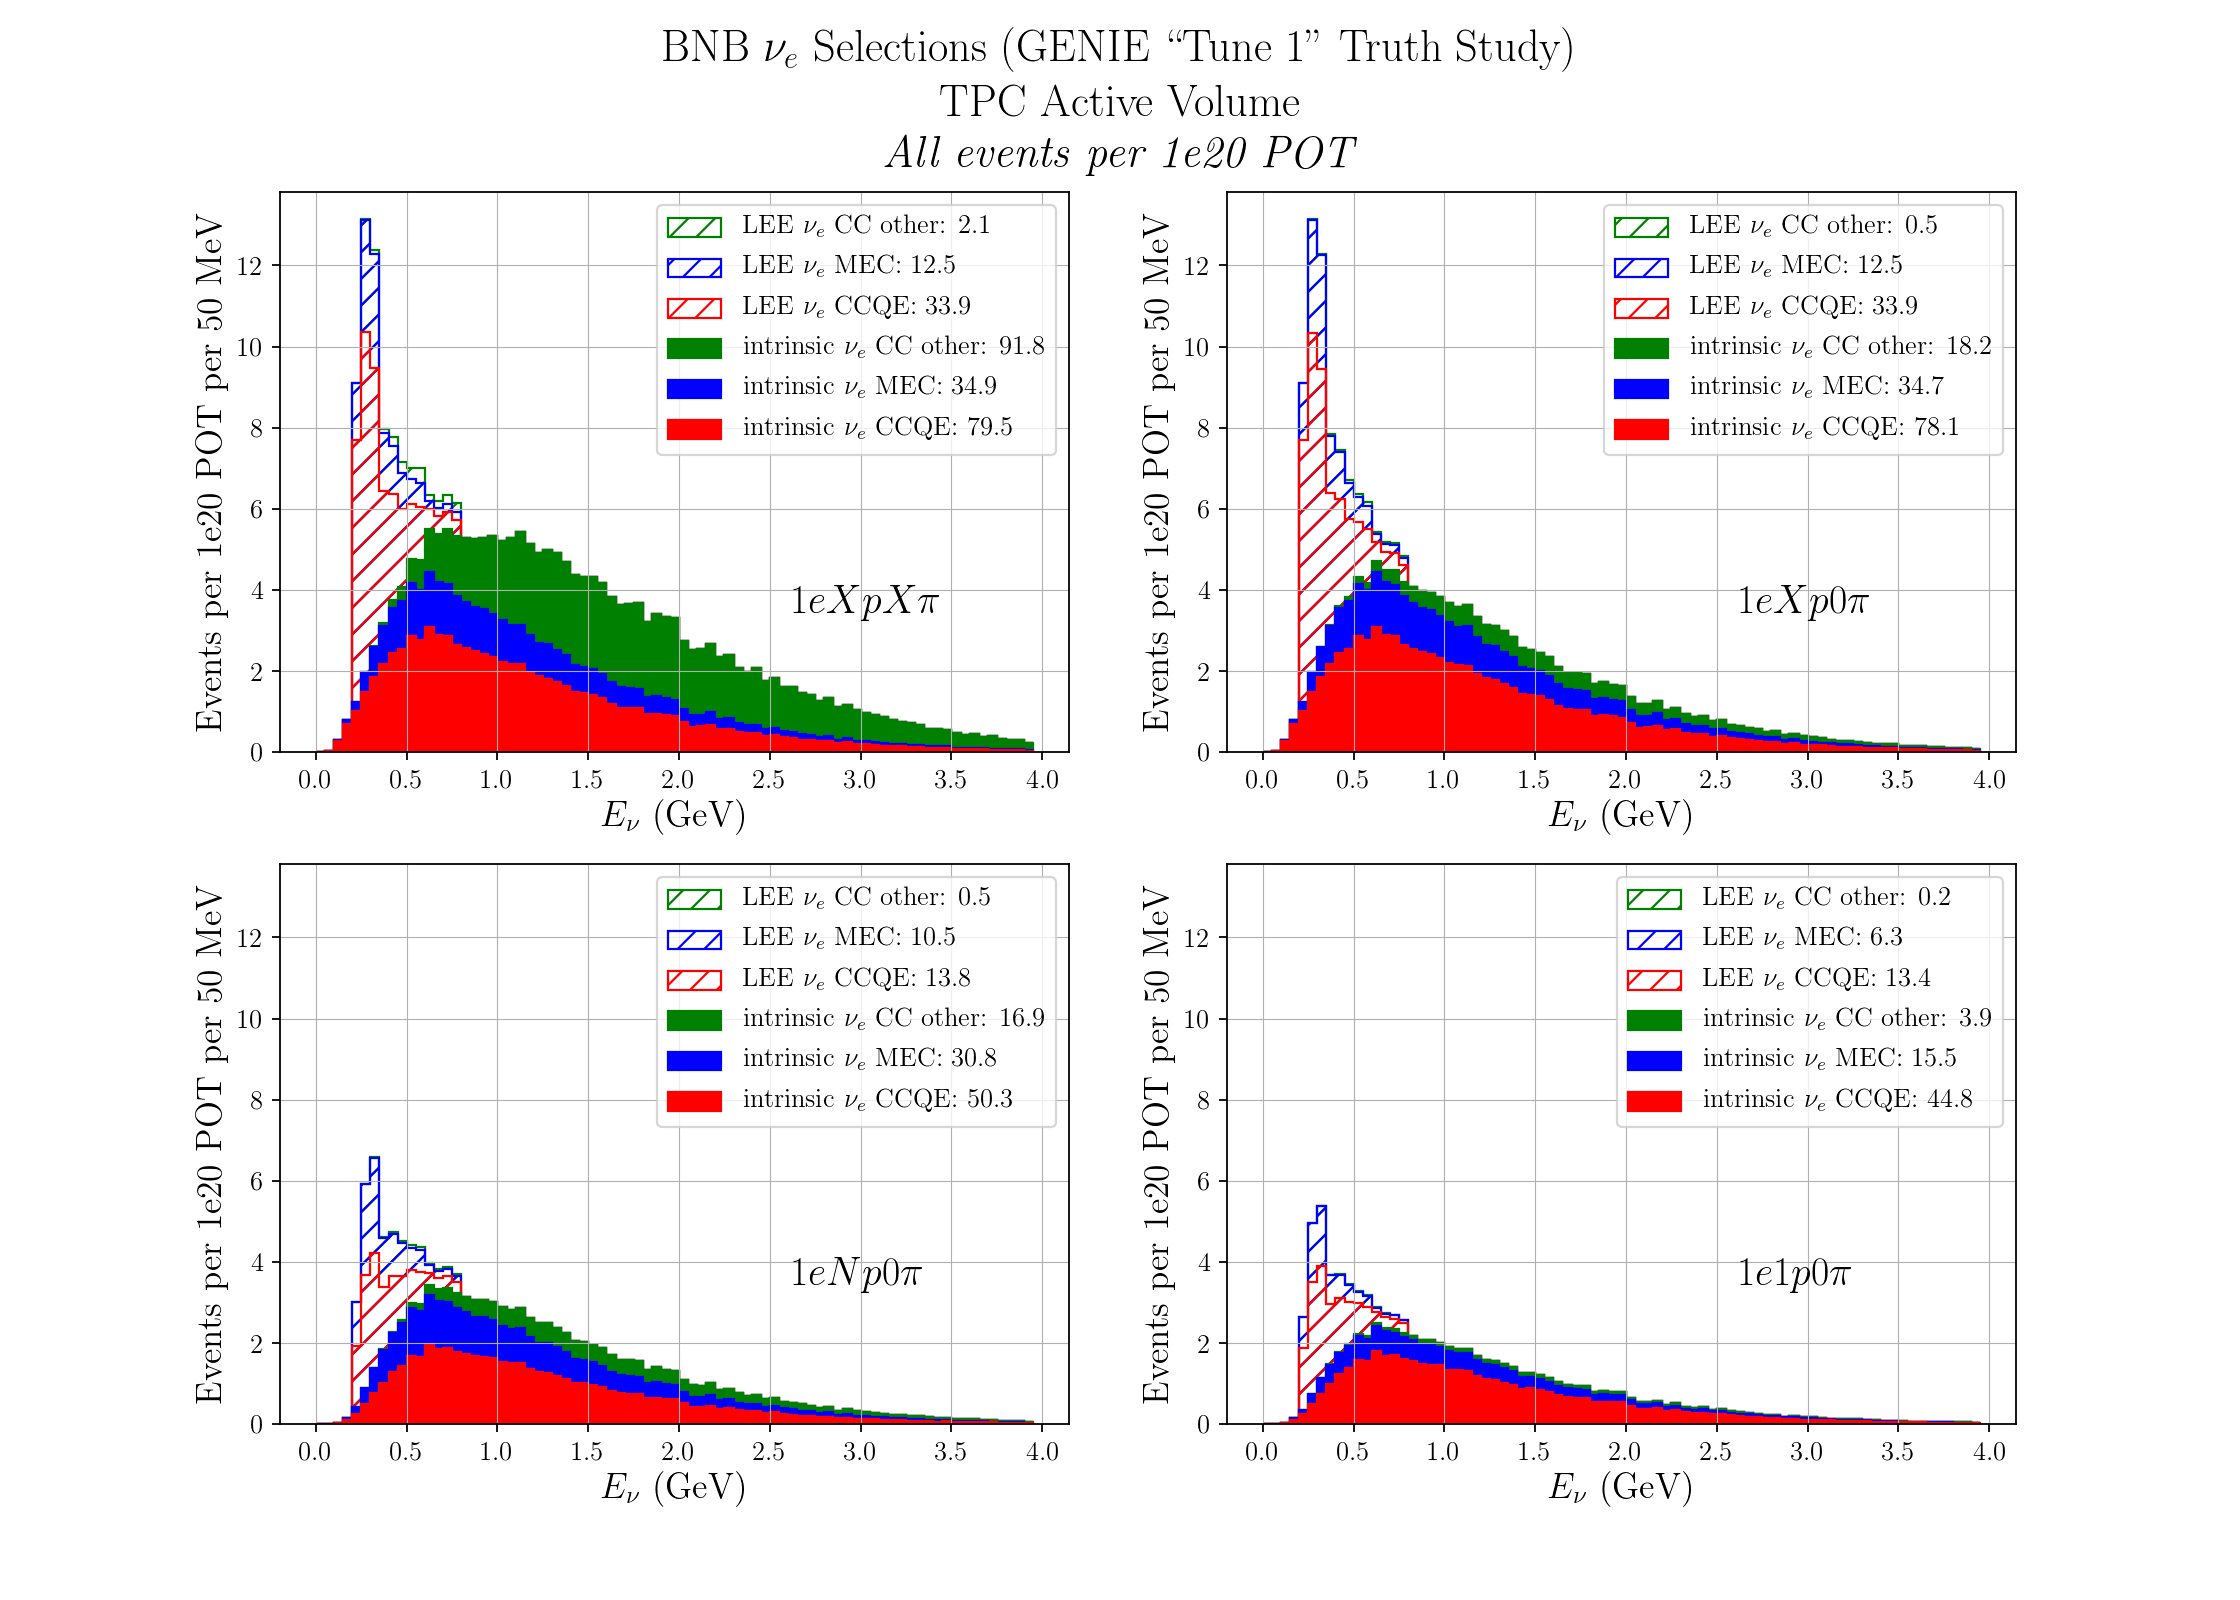

In [26]:
hists_to_plot = [{'var':'e','cut':'mode==0','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CCQE','color':'red','hatch':'','fill':True},
                 {'var':'e','cut':'mode==10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ MEC','color':'blue','hatch':'','fill':True},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'nue_weight',
                  'label':'intrinsic $\\nu_e$ CC other','color':'green','hatch':'','fill':True},
                 {'var':'e','cut':'mode==0','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CCQE','color':'red','hatch':'//','fill':False},
                 {'var':'e','cut':'mode==10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ MEC','color':'blue','hatch':'//','fill':False},
                 {'var':'e','cut':'mode!=0 and mode!=10','weight':'lee_weight',
                  'label':'LEE $\\nu_e$ CC other','color':'green','hatch':'//','fill':False},
                ]
df_selections = [df_1eXpXpi,
                 df_1eXp0pi,
                 df_1eNp0pi,
                 df_1e1p0pi]
sel_labels = ["$1e Xp X\pi$",
              "$1e Xp 0\pi$",
              "$1e Np 0\pi$",
              "$1e 1p 0\pi$"]

bins_energy = np.arange(0,4.0,0.05)

fig,ax = plt.subplots(2,2,sharey='all',figsize=(14.0,10.0))
ax = [item for sublist in ax for item in sublist]
#myaxes = [ax[0][0],ax[0][1],ax[1][0],ax[1][1]]

for i in range(0,len(df_selections)):
    
    make_hists(df=df_selections[i],hists=hists_to_plot,bins=bins_energy,axis=ax[i])
    
    ax[i].grid(axis='both', linewidth=0.5)
    ax[i].yaxis.set_tick_params(labelleft=True)
    ax[i].text(0.65, 0.3, sel_labels[i], transform=ax[i].transAxes, fontsize=18,verticalalignment='top')
    ax[i].set_xlabel("$E_\\nu$ (GeV)",fontsize=16)
    ax[i].set_ylabel("Events per 1e20 POT per 50 MeV",fontsize=16)
    ax[i].legend()

fig.suptitle("BNB $\\nu_e$ Selections (GENIE ``Tune 1'' Truth Study)\nTPC Active Volume\n\\textit{All events per 1e20 POT}",
             fontsize=20)
plt.show()
plt.savefig("plots/nue_selections_energy_events_stacked_inttype_2x2.pdf")